# Exploratory analysis of Carbon Emissions data

Analyze data collected by the Energy Information Administration (EIA) on US Electric Power Industry estimated emissions by state annually from 1990 to 2015.

Additionally, normalize emissions produced by net generation (MWh) per energy source for each year derived from another dataset.

Data is taken from the website <http://www.eia.gov/electricity/data/state/> and can be read from the following source: <www.eia.gov/electricity/data/state/emission_annual.xls>
<www.eia.gov/electricity/data/state/annual_generation_state.xls>

First step: Import packages and libraries

In [5]:
import numpy as np
import pandas as pd
% matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns  

/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Read in data

In [6]:
#read in emissions data
import urllib2
link = 'http://www.eia.gov/electricity/data/state/emission_annual.xls'
socket = urllib2.urlopen(link)
xd = pd.ExcelFile(socket)
xd.sheet_names

#read in net generation data
link2 = 'http://www.eia.gov/electricity/data/state/annual_generation_state.xls'
socket2 = urllib2.urlopen(link2)
xd2 = pd.ExcelFile(socket2)
xd2.sheet_names

[u'Net_Generation_1990-2015 Final']

In [7]:
#Notes page of emissions data
df = xd.parse(xd.sheet_names[-1], header=None)
df

,0
0,"Coal includes anthracite, bituminous coal, sub..."
1,Petroleum includes distillate fuel oil (all di...
2,Wood and Wood Derived Fuels includes paper pel...
3,"Other Biomass includes landfill gas, sludge wa..."
4,"Other Gases includes blast furnace gas, and ot..."
5,"Other includes municipal solid waste, batterie..."
6,NOTE: In prior publications some CO2 emissions...


In [8]:
#Net generation data
netgen = xd2.parse(xd2.sheet_names[0], header=1)
netgen.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,AK,Total Electric Power Industry,Total,5599506.0
1,1990,AK,Total Electric Power Industry,Coal,510573.0
2,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521.0
3,1990,AK,Total Electric Power Industry,Natural Gas,3466261.0
4,1990,AK,Total Electric Power Industry,Petroleum,497116.0


In [9]:
#State Emissions
stemissions = xd.parse(xd.sheet_names[0])
stemissions.head()

,Year,State,Producer Type,Energy Source,CO2 (Metric Tons),SO2 (Metric Tons),NOx (Metric Tons)
0,1990,AK,Commercial Cogen,All Sources,824004,13198,3011
1,1990,AK,Commercial Cogen,Coal,821929,13191,3009
2,1990,AK,Commercial Cogen,Petroleum,2075,6,2
3,1990,AK,Commercial Non-Cogen,All Sources,0,149,42
4,1990,AK,Commercial Non-Cogen,Petroleum,0,149,42


Print shape of DataFrame and confirm number of observations

In [10]:
print "Number of rows in emissions data, columns:", stemissions.shape
print "Number of observations in emissions data:", len(stemissions)

print "Number of rows in net generation data, columns:", netgen.shape
print "Number of observations in net generation data:", len(netgen)

Number of rows in emissions data, columns: (37181, 7)
Number of observations in emissions data: 37181
Number of rows in net generation data, columns: (45350, 5)
Number of observations in net generation data: 45350


Identify missing data

In [11]:
print "Missing data in each column of state emissions data:", stemissions.isnull().sum()
print "Missing data in each column of net generation data:", netgen.isnull().sum()

Missing data in each column of state emissions data: Year                  0
State                 0
Producer Type         0
Energy Source         0
CO2\n(Metric Tons)    0
SO2\n(Metric Tons)    0
NOx\n(Metric Tons)    0
dtype: int64
Missing data in each column of net generation data: YEAR                          0
STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64


In [12]:
stemissions = stemissions.rename(columns={'Producer Type': 'Producer', 'Energy Source': 'Source', 'CO2\n(Metric Tons)': 'co2', 'SO2\n(Metric Tons)': 'so2', 'NOx\n(Metric Tons)': 'nox'})
for col in stemissions.columns.values:
    print col
stemissions.columns

Year
State
Producer
Source
co2
so2
nox


Index([u'Year', u'State', u'Producer', u'Source', u'co2', u'so2', u'nox'], dtype='object')

In [13]:
netgen = netgen.rename(columns={'YEAR': 'Year', 'STATE': 'State', 'TYPE OF PRODUCER': 'Producer', 'ENERGY SOURCE': 'Source', 'GENERATION (Megawatthours)': 'generation'})
for col in netgen.columns.values:
    print col
netgen.columns

Year
State
Producer
Source
generation


Index([u'Year', u'State', u'Producer', u'Source', u'generation'], dtype='object')

Describe the data

In [14]:
stemissions.describe()

,Year,co2,so2,nox
count,37181.000000,3.718100e+04,3.718100e+04,3.718100e+04
mean,2003.210968,1.271159e+07,5.627466e+04,2.715573e+04
std,7.313287,1.004890e+08,5.211070e+05,2.454348e+05
min,1990.000000,-1.200000e+01,0.000000e+00,0.000000e+00
25%,1997.000000,4.150000e+02,1.000000e+00,8.400000e+01
50%,2003.000000,1.357310e+05,4.900000e+01,6.620000e+02
75%,2010.000000,1.876340e+06,4.214000e+03,4.425000e+03
max,2015.000000,2.547032e+09,1.546152e+07,7.996658e+06


In [15]:
netgen.describe()

,Year,generation
count,45350.000000,4.535000e+04
mean,2003.296185,1.717360e+07
std,7.470774,1.324866e+08
min,1990.000000,-8.823445e+06
25%,1997.000000,2.845025e+04
50%,2004.000000,3.476261e+05
75%,2010.000000,3.469870e+06
max,2015.000000,4.156745e+09


Summarize data

In [16]:
stemissions.describe()

,Year,co2,so2,nox
count,37181.000000,3.718100e+04,3.718100e+04,3.718100e+04
mean,2003.210968,1.271159e+07,5.627466e+04,2.715573e+04
std,7.313287,1.004890e+08,5.211070e+05,2.454348e+05
min,1990.000000,-1.200000e+01,0.000000e+00,0.000000e+00
25%,1997.000000,4.150000e+02,1.000000e+00,8.400000e+01
50%,2003.000000,1.357310e+05,4.900000e+01,6.620000e+02
75%,2010.000000,1.876340e+06,4.214000e+03,4.425000e+03
max,2015.000000,2.547032e+09,1.546152e+07,7.996658e+06


In [17]:
netgen.describe()

,Year,generation
count,45350.000000,4.535000e+04
mean,2003.296185,1.717360e+07
std,7.470774,1.324866e+08
min,1990.000000,-8.823445e+06
25%,1997.000000,2.845025e+04
50%,2004.000000,3.476261e+05
75%,2010.000000,3.469870e+06
max,2015.000000,4.156745e+09


Apply Boolean indexing to identify emissions by energy source for entire US for total electric power industry over all years

In [18]:
stemissions.loc[(stemissions["Producer"]=="Total Electric Power Industry") & (stemissions["State"]=="US-TOTAL"), ["Year","Source","co2","so2","nox"]].head()

,Year,Source,co2,so2,nox
946,1990,All Sources,1953698942,15461524,7961276
947,1990,Coal,1592394845,14280722,7118916
948,1990,Geothermal,383992,0,0
949,1990,Natural Gas,233851696,1109,512875
950,1990,Other,7488350,242719,121544


Replace the category "All Sources" to "Total" in the emissions dataset in order for the categories to be the same across the two datasets

In [19]:
stemissions.Source.replace(['All Sources'], ['Total'], inplace=True)
stemissions.head()

,Year,State,Producer,Source,co2,so2,nox
0,1990,AK,Commercial Cogen,Total,824004,13198,3011
1,1990,AK,Commercial Cogen,Coal,821929,13191,3009
2,1990,AK,Commercial Cogen,Petroleum,2075,6,2
3,1990,AK,Commercial Non-Cogen,Total,0,149,42
4,1990,AK,Commercial Non-Cogen,Petroleum,0,149,42


In [20]:
#Create dataframe with US emissions data for Total Electric Power Industry by year 
ustotal = stemissions.loc[(stemissions["Producer"]=="Total Electric Power Industry") & (stemissions["State"]=="US-TOTAL"), ["Year","Source","co2","so2","nox"]]
ustotal.head(1)

,Year,Source,co2,so2,nox
946,1990,Total,1953698942,15461524,7961276


In [255]:
#Describe the US total data
ustotal.describe()

,Year,co2,so2,nox
count,219.000000,2.190000e+02,2.190000e+02,2.190000e+02
mean,2003.219178,5.395316e+08,2.388526e+06,1.152600e+06
std,7.220473,8.584970e+08,4.484890e+06,2.090718e+06
min,1990.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1997.000000,2.415350e+04,1.308500e+03,4.746350e+04
50%,2003.000000,1.435449e+07,3.596100e+04,1.078970e+05
75%,2009.000000,5.149492e+08,9.834690e+05,6.314200e+05
max,2015.000000,2.547032e+09,1.546152e+07,7.996658e+06


In [256]:
#Show emissions for each year
print ustotal[ustotal["Source"]=="Total"]

       Year Source         co2       so2      nox
946    1990  Total  1953698942  15461524  7961276
2021   1991  Total  1950465707  15342434  7913120
3134   1992  Total  1972275109  15030302  7728355
4273   1993  Total  2057052600  14965892  7996658
5428   1994  Total  2088138401  14471944  7801077
6814   1995  Total  2108006095  12313856  6354985
8236   1996  Total  2186979641  12991297  6474173
9675   1997  Total  2259321520  13479681  6500391
11124  1998  Total  2351599517  13464481  6458698
12568  1999  Total  2366302296  12843369  5955499
14042  2000  Total  2470834445  11903806  5638125
15529  2001  Total  2418606723  11174367  5289879
17020  2002  Total  2423963090  10881432  5193632
18531  2003  Total  2445094300  10645809  4531725
20053  2004  Total  2486981558  10308805  4143036
21572  2005  Total  2543838163  10339543  3961097
23078  2006  Total  2488917751   9523561  3799447
24600  2007  Total  2547032486   9041697  3650010
26109  2008  Total  2484012111   7829798  3330223


In [253]:
#Create dataframe with US net generation data for Total Electric Power Industry by year 
ustotnetgen = netgen.loc[(netgen["Producer"]=="Total Electric Power Industry") & ((netgen["State"]=="US-Total") | (netgen["State"]=="US-TOTAL")), ["Year","Source","generation"]]
print ustotnetgen.head()
print ustotnetgen.tail()

      Year                      Source    generation
1189  1990                       Total  3.037827e+09
1190  1990                        Coal  1.594011e+09
1191  1990                  Geothermal  1.543427e+07
1192  1990  Hydroelectric Conventional  2.928658e+08
1193  1990                 Natural Gas  3.727652e+08
       Year                          Source   generation
45024  2015                       Petroleum   28248749.0
45025  2015  Solar Thermal and Photovoltaic   24892904.0
45026  2015                   Other Biomass   21703372.0
45027  2015                            Wind  190718548.0
45028  2015     Wood and Wood Derived Fuels   41928506.0


In [254]:
#Show generation for each year
print ustotnetgen[ustotnetgen["Source"]=="Total"]

       Year Source    generation
1189   1990  Total  3.037827e+09
2660   1991  Total  3.073799e+09
4151   1992  Total  3.083882e+09
5671   1993  Total  3.197191e+09
7208   1994  Total  3.247522e+09
8769   1995  Total  3.353487e+09
10344  1996  Total  3.444188e+09
11941  1997  Total  3.492172e+09
13538  1998  Total  3.620295e+09
15142  1999  Total  3.694810e+09
16791  2000  Total  3.802105e+09
18497  2001  Total  3.736644e+09
20262  2002  Total  3.858452e+09
22044  2003  Total  3.883185e+09
23839  2004  Total  3.970555e+09
25639  2005  Total  4.055423e+09
27446  2006  Total  4.064702e+09
29274  2007  Total  4.156745e+09
31143  2008  Total  4.119388e+09
33033  2009  Total  3.950331e+09
34961  2010  Total  4.125060e+09
36904  2011  Total  4.100141e+09
38887  2012  Total  4.047765e+09
40906  2013  Total  4.065964e+09
42962  2014  Total  4.093606e+09
45015  2015  Total  4.077601e+09


In [23]:
#Observe mean amount CO2, SO2 and NOx emissions per energy source over the years
print ustotal.pivot_table(values=["co2", "so2", "nox"], index=["Source"], aggfunc=np.mean)

                                      co2           nox           so2
Source                                                               
Coal                         1.800385e+09  3.959244e+06  9.186064e+06
Geothermal                   3.830763e+05  0.000000e+00  0.000000e+00
Natural Gas                  3.773925e+08  4.770651e+05  2.064038e+03
Other                        1.297888e+07  6.955758e+04  6.862473e+04
Other Biomass                0.000000e+00  7.144848e+04  1.736286e+03
Other Gases                  4.207681e+04  2.854552e+04  8.574762e+02
Petroleum                    8.108516e+07  1.958447e+05  6.129495e+05
Total                        2.272258e+09  4.854226e+06  1.005938e+07
Wood and Wood Derived Fuels  0.000000e+00  8.881224e+04  2.322200e+05


In [24]:
#Observe mean amount net generation per energy source over the years
print ustotnetgen.pivot_table(values=["generation"], index=["Source"], aggfunc=np.mean)

                                  generation
Source                                      
Coal                            1.785299e+09
Geothermal                      1.503344e+07
Hydroelectric Conventional      2.808515e+08
Natural Gas                     7.281939e+08
Nuclear                         7.316641e+08
Other                           9.240232e+06
Other Biomass                   1.856036e+07
Other Gases                     1.276801e+07
Petroleum                       8.250165e+07
Pumped Storage                 -5.535791e+06
Solar Thermal and Photovoltaic  2.685224e+06
Total                           3.744340e+09
Wind                            4.554843e+07
Wood and Wood Derived Fuels     3.753039e+07


Create tables for each energy source

Create visualizations for CO2 emissions over years for each Energy Source type

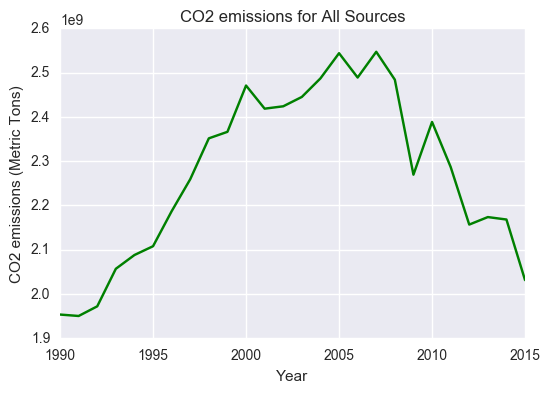

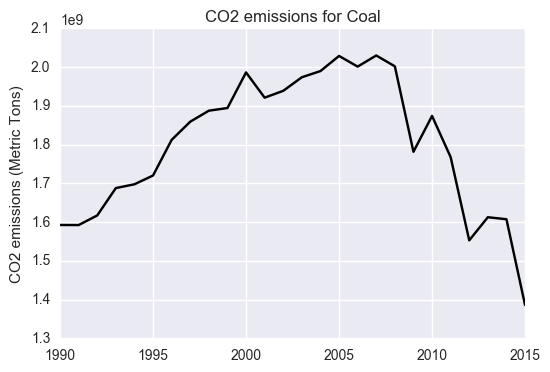

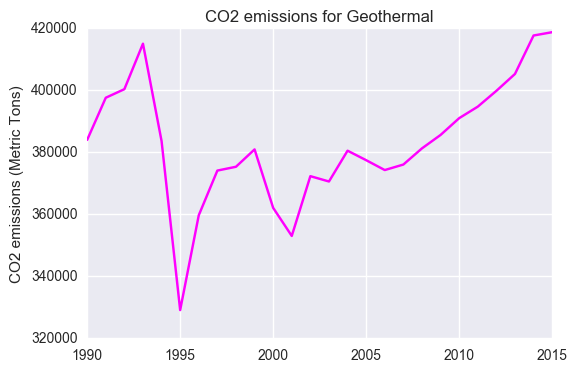

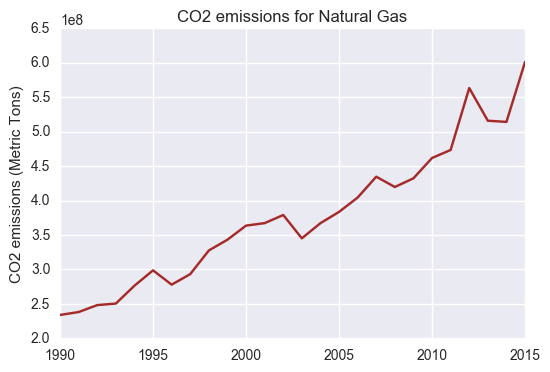

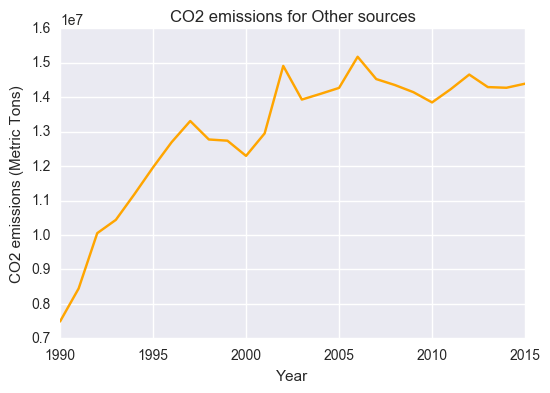

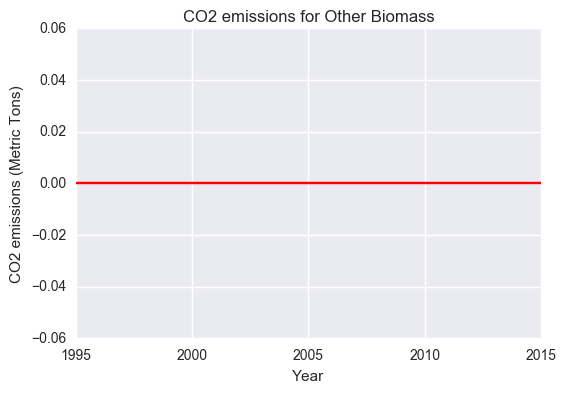

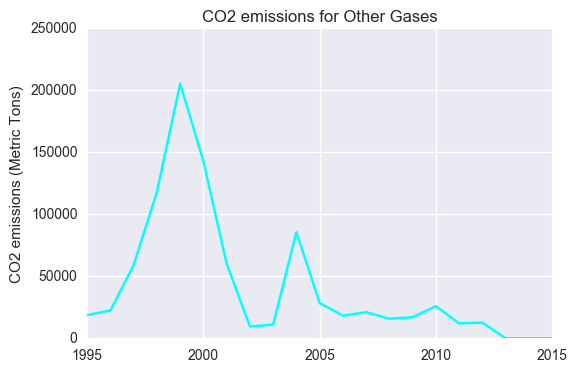

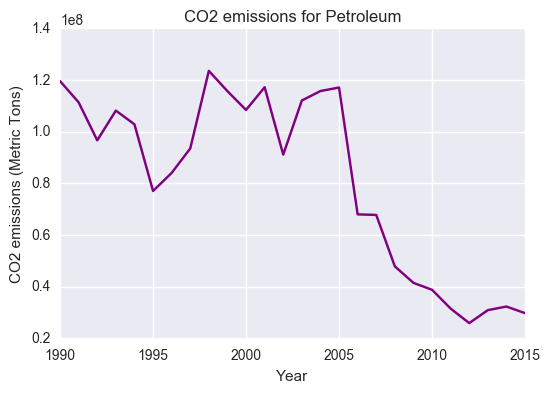

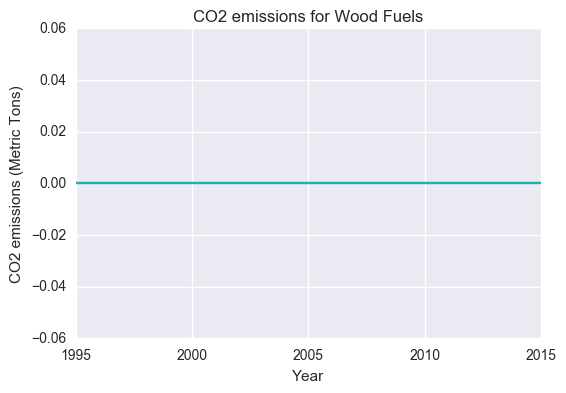

In [274]:
plt.figure(1)
plt.plot(ustotal[ustotal.Source=="Total"].Year, ustotal[ustotal.Source=="Total"].co2, color = 'green')
plt.title('CO2 emissions for All Sources')
plt.ylabel('CO2 emissions (Metric Tons)')
plt.xlabel('Year')

plt.figure(2)
plt.plot(ustotal[ustotal.Source=="Coal"].Year, ustotal[ustotal.Source=="Coal"].co2, color = 'black')
plt.title('CO2 emissions for Coal')
plt.ylabel('CO2 emissions (Metric Tons)')
#plt.xlabel('Year')

plt.figure(3)
plt.plot(ustotal[ustotal.Source=="Geothermal"].Year, ustotal[ustotal.Source=="Geothermal"].co2, color = 'magenta')
plt.title('CO2 emissions for Geothermal')
plt.ylabel('CO2 emissions (Metric Tons)')
#plt.xlabel('Year')

plt.figure(4)
plt.plot(ustotal[ustotal.Source=="Natural Gas"].Year, ustotal[ustotal.Source=="Natural Gas"].co2, color = 'brown')
plt.title('CO2 emissions for Natural Gas')
plt.ylabel('CO2 emissions (Metric Tons)')
#plt.xlabel('Year')

plt.figure(5)
plt.plot(ustotal[ustotal.Source=="Other"].Year, ustotal[ustotal.Source=="Other"].co2, color = 'orange')
plt.title('CO2 emissions for Other sources')
plt.ylabel('CO2 emissions (Metric Tons)')
plt.xlabel('Year')

plt.figure(6)
plt.plot(ustotal[ustotal.Source=="Other Biomass"].Year, ustotal[ustotal.Source=="Other Biomass"].co2, color = 'red')
plt.title('CO2 emissions for Other Biomass')
plt.ylabel('CO2 emissions (Metric Tons)')
plt.xlabel('Year')

plt.figure(7)
plt.plot(ustotal[ustotal.Source=="Other Gases"].Year, ustotal[ustotal.Source=="Other Gases"].co2, color = 'cyan')
plt.title('CO2 emissions for Other Gases')
plt.ylabel('CO2 emissions (Metric Tons)')
#plt.xlabel('Year')

plt.figure(8)
plt.plot(ustotal[ustotal.Source=="Petroleum"].Year, ustotal[ustotal.Source=="Petroleum"].co2, color = 'purple')
plt.title('CO2 emissions for Petroleum')
plt.ylabel('CO2 emissions (Metric Tons)')
plt.xlabel('Year')

plt.figure(9)
plt.plot(ustotal[ustotal.Source=="Wood and Wood Derived Fuels"].Year, ustotal[ustotal.Source=="Wood and Wood Derived Fuels"].co2, color = 'lightseagreen')
plt.title('CO2 emissions for Wood Fuels')
plt.ylabel('CO2 emissions (Metric Tons)')
plt.xlabel('Year')



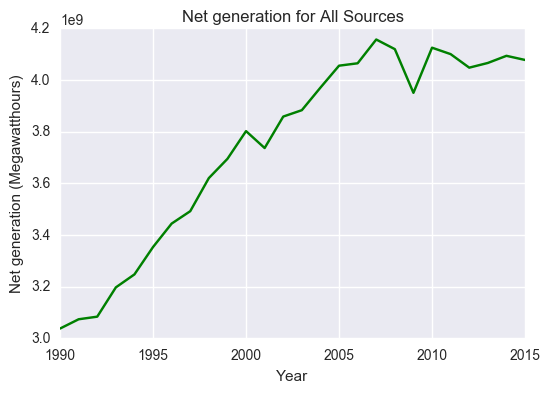

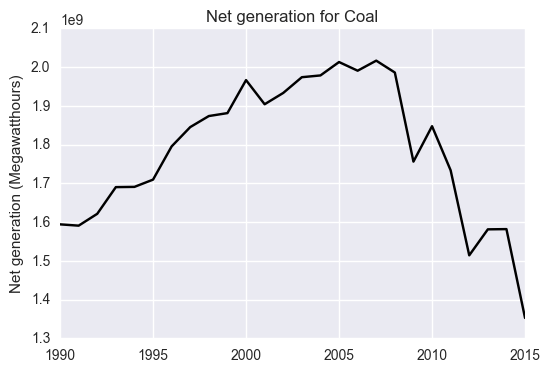

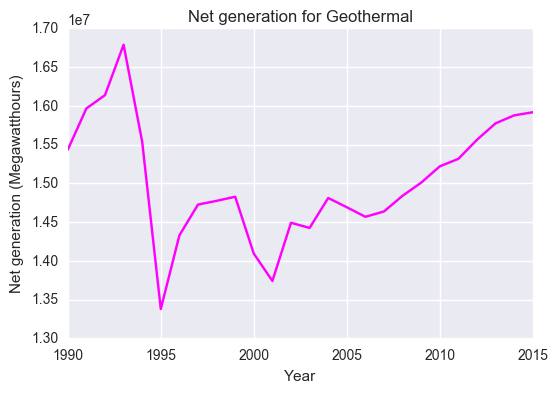

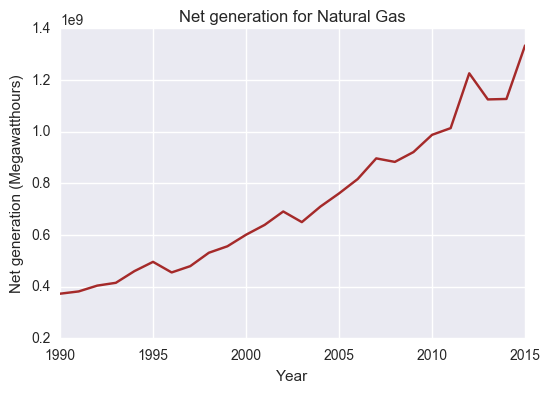

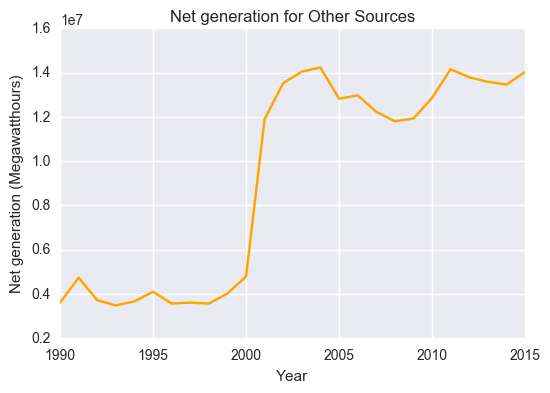

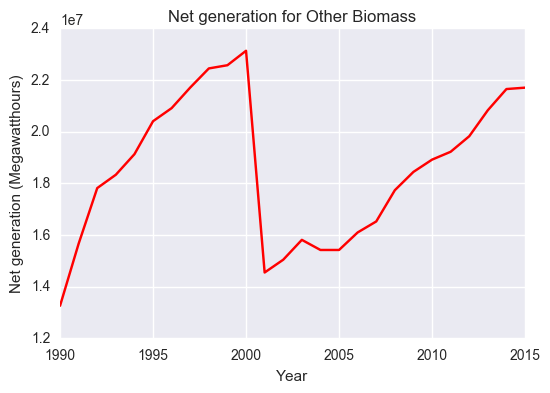

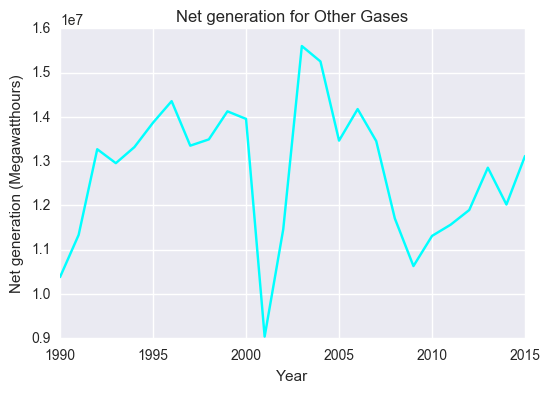

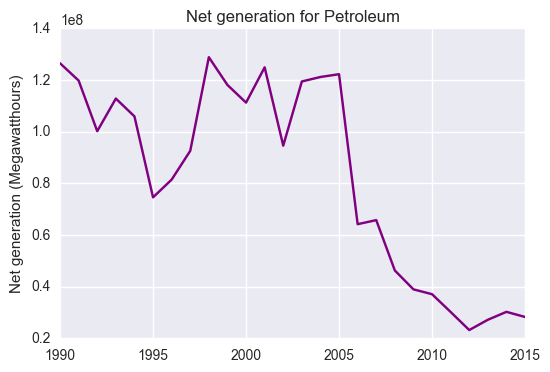

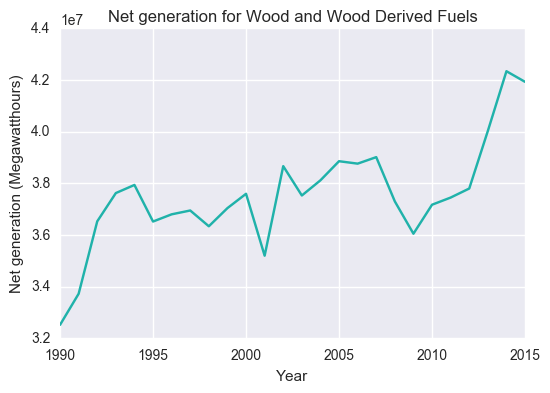

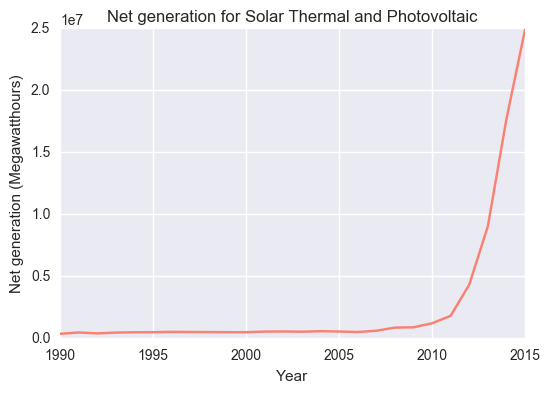

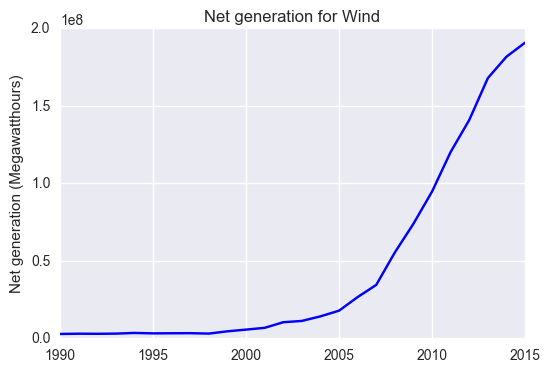

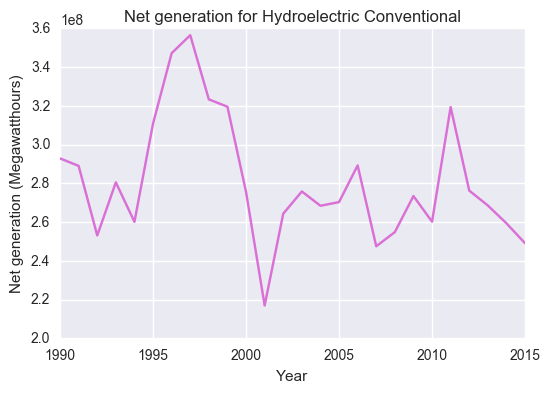

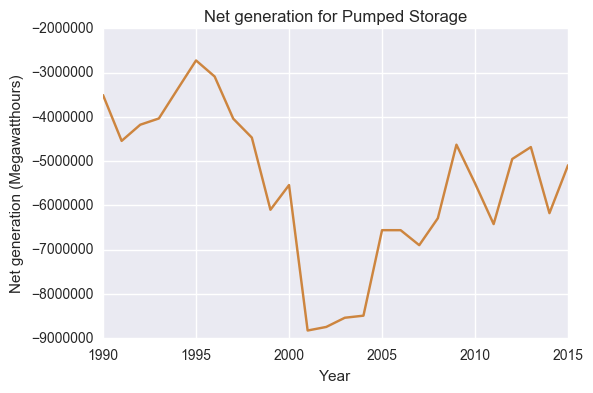

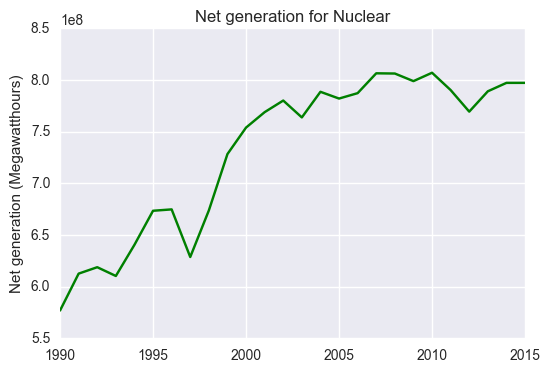

In [278]:
plt.figure(1)
plt.plot(ustotnetgen[ustotnetgen.Source=="Total"].Year, ustotnetgen[ustotnetgen.Source=="Total"].generation, color = 'g')
plt.title('Net generation for All Sources')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(2)
plt.plot(ustotnetgen[ustotnetgen.Source=="Coal"].Year, ustotnetgen[ustotnetgen.Source=="Coal"].generation, color = 'black')
plt.title('Net generation for Coal')
plt.ylabel('Net generation (Megawatthours)')
#plt.xlabel('Year')

plt.figure(3)
plt.plot(ustotnetgen[ustotnetgen.Source=="Geothermal"].Year, ustotnetgen[ustotnetgen.Source=="Geothermal"].generation, color = 'magenta')
plt.title('Net generation for Geothermal')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(4)
plt.plot(ustotnetgen[ustotnetgen.Source=="Natural Gas"].Year, ustotnetgen[ustotnetgen.Source=="Natural Gas"].generation, color = 'brown')
plt.title('Net generation for Natural Gas')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(5)
plt.plot(ustotnetgen[ustotnetgen.Source=="Other"].Year, ustotnetgen[ustotnetgen.Source=="Other"].generation, color = 'orange')
plt.title('Net generation for Other Sources')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(6)
plt.plot(ustotnetgen[ustotnetgen.Source=="Other Biomass"].Year, ustotnetgen[ustotnetgen.Source=="Other Biomass"].generation, color = 'red')
plt.title('Net generation for Other Biomass')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(7)
plt.plot(ustotnetgen[ustotnetgen.Source=="Other Gases"].Year, ustotnetgen[ustotnetgen.Source=="Other Gases"].generation, color = 'cyan')
plt.title('Net generation for Other Gases')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(8)
plt.plot(ustotnetgen[ustotnetgen.Source=="Petroleum"].Year, ustotnetgen[ustotnetgen.Source=="Petroleum"].generation, color = 'purple')
plt.title('Net generation for Petroleum')
plt.ylabel('Net generation (Megawatthours)')
#plt.xlabel('Year')

plt.figure(9)
plt.plot(ustotnetgen[ustotnetgen.Source=="Wood and Wood Derived Fuels"].Year, ustotnetgen[ustotnetgen.Source=="Wood and Wood Derived Fuels"].generation, color = 'lightseagreen')
plt.title('Net generation for Wood and Wood Derived Fuels')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(10)
plt.plot(ustotnetgen[ustotnetgen.Source=="Solar Thermal and Photovoltaic"].Year, ustotnetgen[ustotnetgen.Source=="Solar Thermal and Photovoltaic"].generation, color = 'salmon')
plt.title('Net generation for Solar Thermal and Photovoltaic')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(11)
plt.plot(ustotnetgen[ustotnetgen.Source=="Wind"].Year, ustotnetgen[ustotnetgen.Source=="Wind"].generation, color = 'blue')
plt.title('Net generation for Wind')
plt.ylabel('Net generation (Megawatthours)')
#plt.xlabel('Year')

plt.figure(12)
plt.plot(ustotnetgen[ustotnetgen.Source=="Hydroelectric Conventional"].Year, ustotnetgen[ustotnetgen.Source=="Hydroelectric Conventional"].generation, color = 'orchid')
plt.title('Net generation for Hydroelectric Conventional')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(13)
plt.plot(ustotnetgen[ustotnetgen.Source=="Pumped Storage"].Year, ustotnetgen[ustotnetgen.Source=="Pumped Storage"].generation, color = 'peru')
plt.title('Net generation for Pumped Storage')
plt.ylabel('Net generation (Megawatthours)')
plt.xlabel('Year')

plt.figure(14)
plt.plot(ustotnetgen[ustotnetgen.Source=="Nuclear"].Year, ustotnetgen[ustotnetgen.Source=="Nuclear"].generation, color = 'green')
plt.title('Net generation for Nuclear')
plt.ylabel('Net generation (Megawatthours)')
#plt.xlabel('Year')




Merge state emissions and net generation data

In [27]:
ustotaldata = pd.merge(ustotal, ustotnetgen, how='outer').fillna(0) 
ustotaldata.head(1)

,Year,Source,co2,so2,nox,generation
0,1990.0,Total,1.953699e+09,15461524.0,7961276.0,3.037827e+09


Convert datatype of Year variable in preparation for subsequent index setting

In [28]:
#Change Year variable from series datatype to an integer 
ustotaldata['Year'] = ustotaldata['Year'].astype(np.int64)
#identify datatype of Year variable
print type(ustotaldata['Year'][0])
ustotaldata['Year'].head(2)

<type 'numpy.int64'>


0    1990
1    1990
Name: Year, dtype: int64

Show missing data in newly merged dataset. No missing data is observed.

In [29]:
print "Missing data in each column of merged data:", ustotaldata.isnull().sum()

Missing data in each column of merged data: Year          0
Source        0
co2           0
so2           0
nox           0
generation    0
dtype: int64


Create Date variables and set it as the index

In [260]:
ustotaldata['Month']=12
ustotaldata['Day']=31
ustotaldata['Date']=pd.to_datetime(ustotaldata[['Year', 'Month', 'Day']])
ustotaldata.set_index('Date', inplace=True)
ustotaldata.head(2)

,Year,Source,co2,so2,nox,generation,Month,Day,co2permwh,so2permwh,noxpermwh,co2diff,total_co2,total_so2,total_nox,total_generation,co2_wt,gen_wt
Date,,,,,,,,,,,,,,,,,,
1990-12-31,1990,Total,1.953699e+09,15461524.0,7961276.0,3.037827e+09,12,31,0.643124,0.005090,0.002621,0.0,1.953699e+09,15461524.0,7961276.0,3.037827e+09,1.953699e+09,3.037827e+09
1990-12-31,1990,Coal,1.592395e+09,14280722.0,7118916.0,1.594011e+09,12,31,0.998986,0.008959,0.004466,0.0,1.953699e+09,15461524.0,7961276.0,3.037827e+09,8.355628e+08,1.299226e+09


In [261]:
ustotaldata['Year'] = ustotaldata.index.year
ustotaldata.head(2)
print ustotaldata['2010'].head(1)

            Year Source           co2        so2        nox    generation  \
Date                                                                        
2010-12-31  2010  Total  2.388596e+09  5400450.0  2491024.0  4.125060e+09   

            Month  Day  co2permwh  so2permwh  noxpermwh      co2diff  \
Date                                                                   
2010-12-31     12   31   0.579045   0.001309   0.000604  119088287.0   

               total_co2  total_so2  total_nox  total_generation  \
Date                                                               
2010-12-31  2.388596e+09  5400450.0  2491024.0      4.125060e+09   

                  co2_wt        gen_wt  
Date                                    
2010-12-31  2.388596e+09  4.125060e+09  


Plot net generation for highest producing supply sources

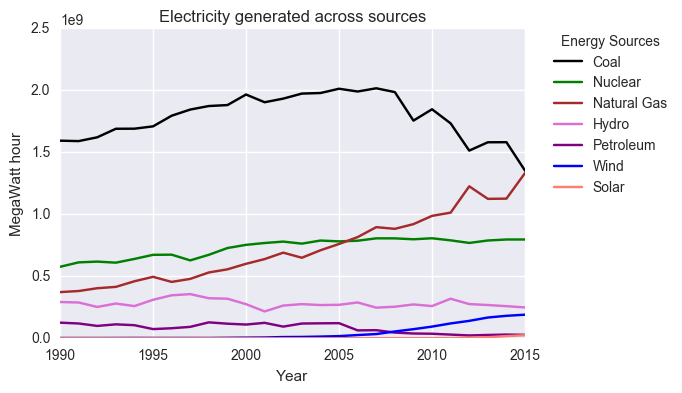

In [279]:
#Plot Net generation for highest producing supply sources: Coal, Nuclear, Natural Gas, Hydro, Petroleum and Wind 
plt.figure(1) 
ustotaldata[ustotaldata.Source=="Coal"].generation.plot(color="black")
ustotaldata[ustotaldata.Source=="Nuclear"].generation.plot(color='green')
ustotaldata[ustotaldata.Source=="Natural Gas"].generation.plot(color='brown')
ustotaldata[ustotaldata.Source=="Hydroelectric Conventional"].generation.plot(color='orchid')
ustotaldata[ustotaldata.Source=="Petroleum"].generation.plot(color='purple')
ustotaldata[ustotaldata.Source=="Wind"].generation.plot(color='blue')
ustotaldata[ustotaldata.Source=="Solar Thermal and Photovoltaic"].generation.plot(color='salmon')
plt.title('Electricity generated across sources')
plt.ylabel('MegaWatt hour')
plt.xlabel('Year')
plt.legend(['Coal','Nuclear','Natural Gas','Hydro','Petroleum','Wind','Solar'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Energy Sources')
plt.show()

Plot CO2 emissions for highest CO2 producing sources

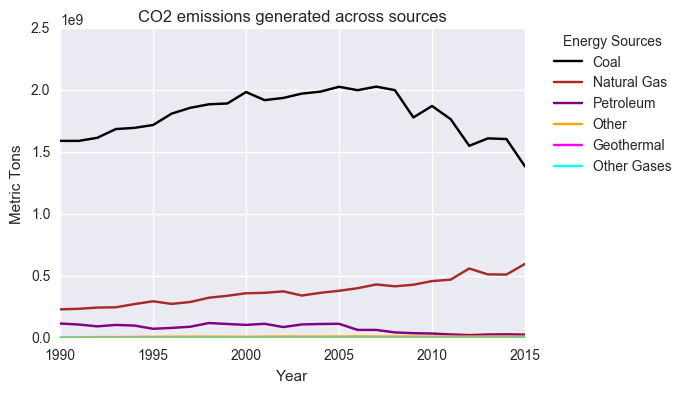

In [267]:
#Plot CO2 emissions for highest emitting sources: Coal, Natural Gas, Petroleum, Other, Geothermal and Other Gases
plt.figure(1) 
ustotaldata[ustotaldata.Source=="Coal"].co2.plot(color="black")
ustotaldata[ustotaldata.Source=="Natural Gas"].co2.plot(color='brown')
ustotaldata[ustotaldata.Source=="Petroleum"].co2.plot(color='purple')
ustotaldata[ustotaldata.Source=="Other"].co2.plot(color='orange')
ustotaldata[ustotaldata.Source=="Geothermal"].co2.plot(color='magenta')
ustotaldata[ustotaldata.Source=="Other Gases"].co2.plot(color='cyan')
plt.title('CO2 emissions generated across sources')
plt.ylabel('Metric Tons')
plt.xlabel('Year')
plt.legend(['Coal','Natural Gas','Petroleum','Other','Geothermal','Other Gases'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Energy Sources')
plt.show()

Create measure of emissions per net generation for each source and year

In [32]:
ustotaldata['co2permwh'] = ustotaldata['co2'] / ustotaldata['generation']
ustotaldata['so2permwh'] = ustotaldata['so2'] / ustotaldata['generation']
ustotaldata['noxpermwh'] = ustotaldata['nox'] / ustotaldata['generation']

ustotaldata.tail(2)

,Year,Source,co2,so2,nox,generation,Month,Day,co2permwh,so2permwh,noxpermwh
Date,,,,,,,,,,,
2015-12-31,2015,Solar Thermal and Photovoltaic,0.0,0.0,0.0,24892904.0,12,31,0.0,0.0,0.0
2015-12-31,2015,Wind,0.0,0.0,0.0,190718548.0,12,31,0.0,0.0,0.0


Construct pivot tables on mean and median amount CO2, SO2 and NOx emissions per Megawatthour of electricity generated 

In [33]:
print ustotaldata.pivot_table(values=["co2permwh", "so2permwh", "noxpermwh"], index=["Source"], aggfunc=np.mean)
print ustotaldata.pivot_table(values=["co2permwh", "so2permwh", "noxpermwh"], index=["Source"], aggfunc=np.median)

                                co2permwh  noxpermwh  so2permwh
Source                                                         
Coal                             1.008741   0.002237   0.005136
Geothermal                       0.025484   0.000000   0.000000
Hydroelectric Conventional       0.000000   0.000000   0.000000
Natural Gas                      0.541917   0.000798   0.000003
Nuclear                          0.000000   0.000000   0.000000
Other                            1.861213   0.012662   0.016322
Other Biomass                    0.000000   0.003064   0.000076
Other Gases                      0.002575   0.001826   0.000052
Petroleum                        1.006604   0.002319   0.007041
Pumped Storage                   0.000000   0.000000   0.000000
Solar Thermal and Photovoltaic   0.000000   0.000000   0.000000
Total                            0.609522   0.001366   0.002812
Wind                             0.000000   0.000000   0.000000
Wood and Wood Derived Fuels      0.00000

Identify the energy sources associated with high emissions based on the pivot tables above (i.e. Total, Coal, Other, Petroleum, Natural Gas, Geothermal) 

Plot trend lines of CO2 per MWh over time for energy sources with high emissions

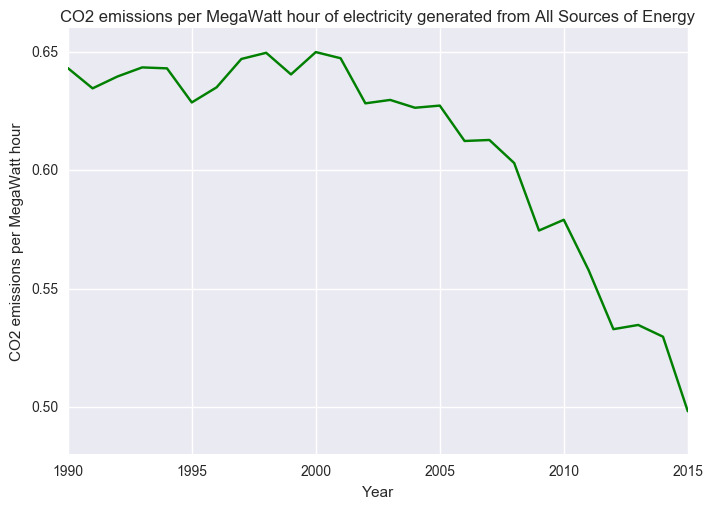

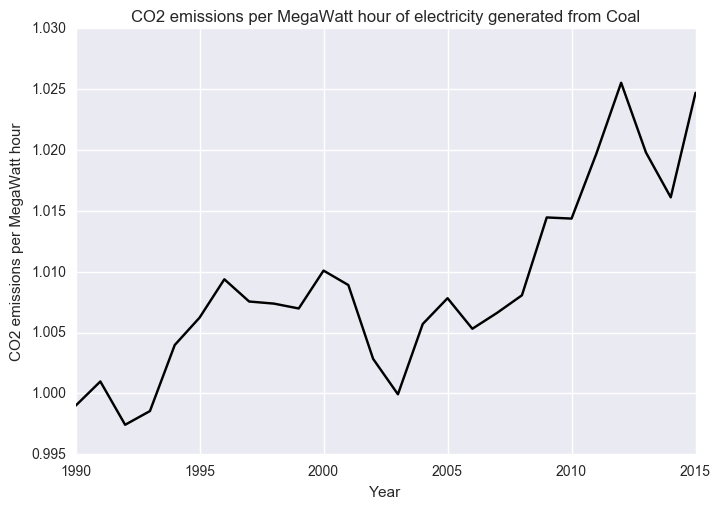

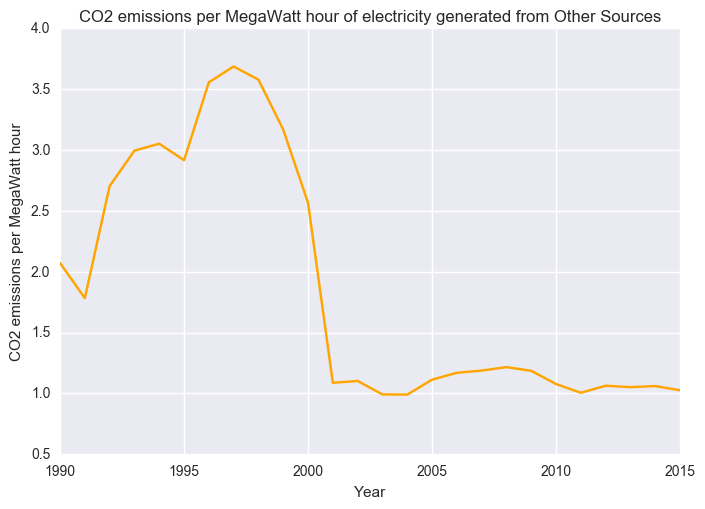

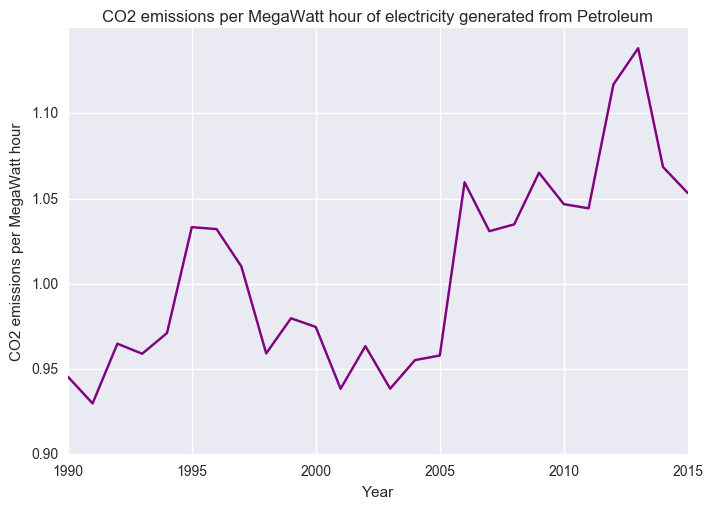

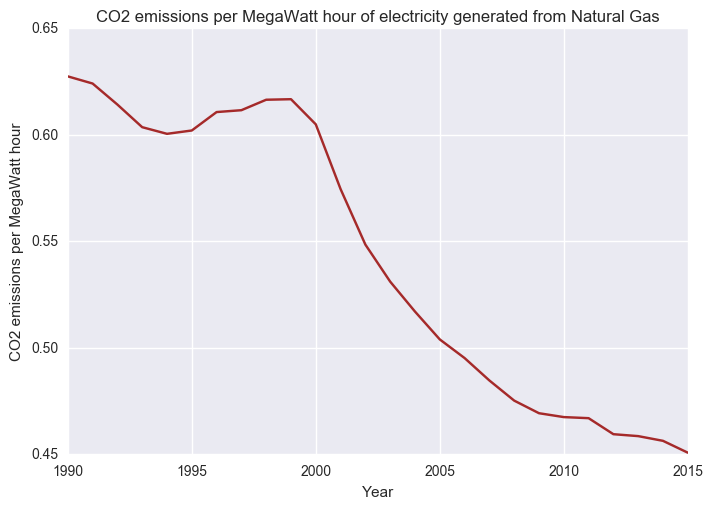

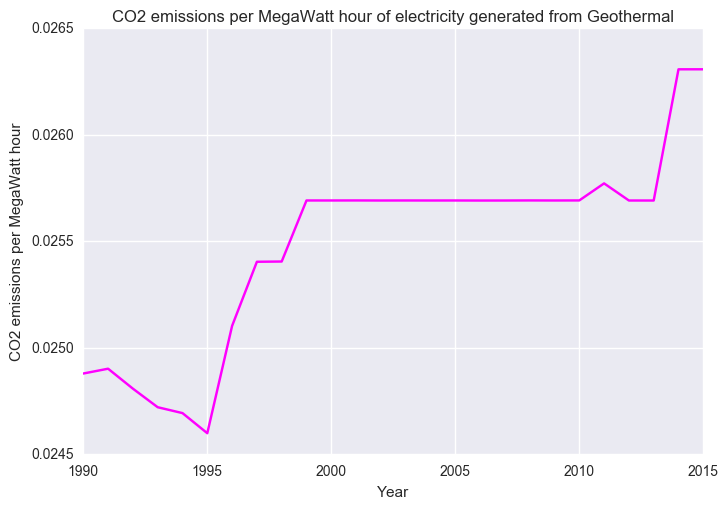

In [34]:
plt.figure(1)
ustotaldata[ustotaldata.Source=="Total"].co2permwh.plot(color="green")
plt.title('CO2 emissions per MegaWatt hour of electricity generated from All Sources of Energy')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

plt.figure(2)
ustotaldata[ustotaldata.Source=="Coal"].co2permwh.plot(color='black')
plt.title('CO2 emissions per MegaWatt hour of electricity generated from Coal')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

plt.figure(3)
ustotaldata[ustotaldata.Source=="Other"].co2permwh.plot(color='orange')
plt.title('CO2 emissions per MegaWatt hour of electricity generated from Other Sources')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

plt.figure(4)
ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh.plot(color='purple')
plt.title('CO2 emissions per MegaWatt hour of electricity generated from Petroleum')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

plt.figure(5)
ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh.plot(color='brown')
plt.title('CO2 emissions per MegaWatt hour of electricity generated from Natural Gas')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

plt.figure(6)
ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh.plot(color='magenta')
plt.title('CO2 emissions per MegaWatt hour of electricity generated from Geothermal')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')

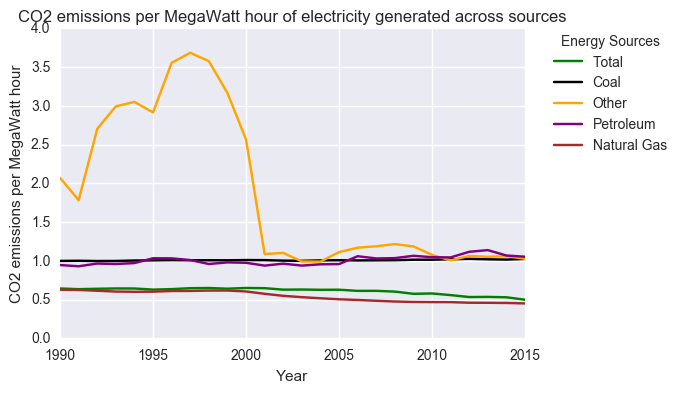

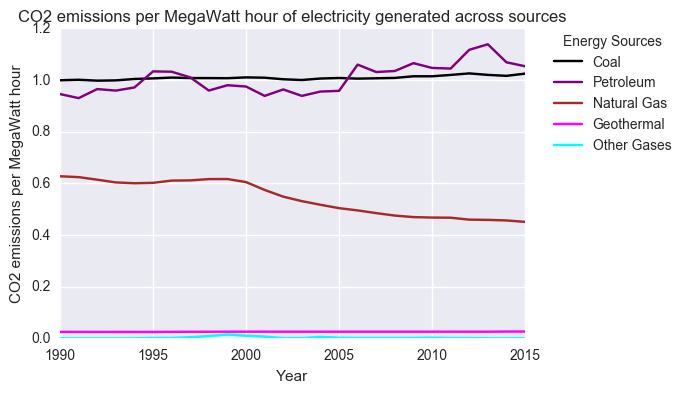

In [280]:
#Plot CO2 per MWh generated for Total, Coal, Other, Petroleum and Natural Gas 
plt.figure(1) 
ustotaldata[ustotaldata.Source=="Total"].co2permwh.plot(color="green")
ustotaldata[ustotaldata.Source=="Coal"].co2permwh.plot(color='black')
ustotaldata[ustotaldata.Source=="Other"].co2permwh.plot(color='orange')
ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh.plot(color='purple')
ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh.plot(color='brown')
plt.title('CO2 emissions per MegaWatt hour of electricity generated across sources')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')
plt.legend(['Total','Coal','Other','Petroleum','Natural Gas'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Energy Sources')
plt.show()

#Plot CO2 per MWh generated for Coal, Petroleum, Natural Gas, Geothermal and Other Gases - take out Other to show deviations of primary generation sources 
plt.figure(2)
ustotaldata[ustotaldata.Source=="Coal"].co2permwh.plot(color='black')
ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh.plot(color='purple')
ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh.plot(color='brown')
ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh.plot(color='magenta')
ustotaldata[ustotaldata.Source=="Other Gases"].co2permwh.plot(color='cyan')
plt.title('CO2 emissions per MegaWatt hour of electricity generated across sources')
plt.ylabel('CO2 emissions per MegaWatt hour')
plt.xlabel('Year')
plt.legend(['Coal','Petroleum','Natural Gas','Geothermal','Other Gases'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Energy Sources')
plt.show()

Smooth out random variations over time by plotting rolling averages over defined time intervals.

Plot the 5-year rolling mean of CO2 emissions per MWh for All Sources, Coal, Petroleum, Natural Gas, Other Sources, and Geothermal

/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
  from ipykernel import kernelapp as app
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=

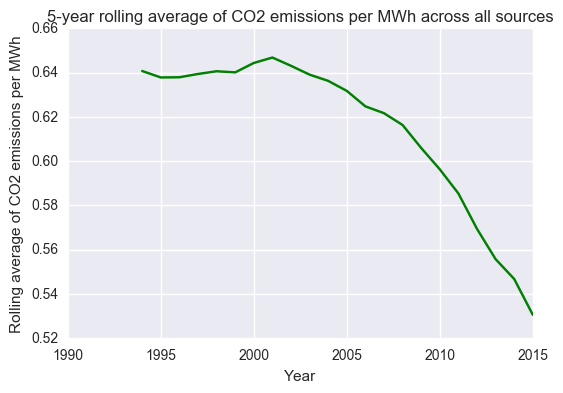

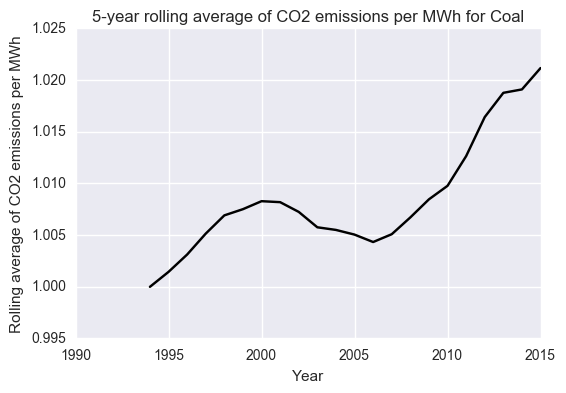

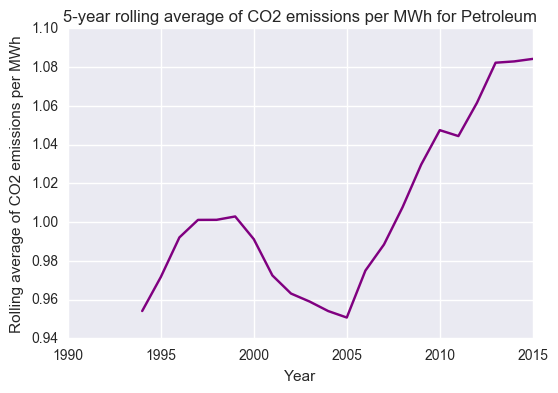

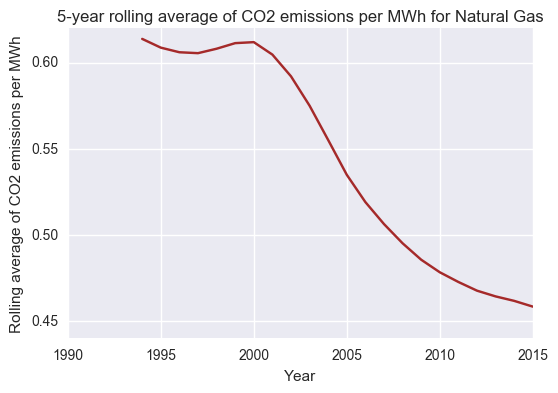

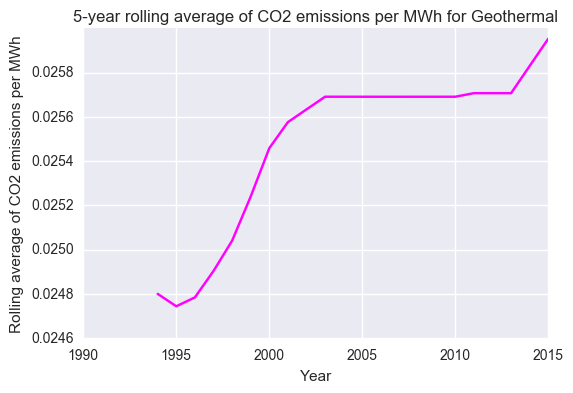

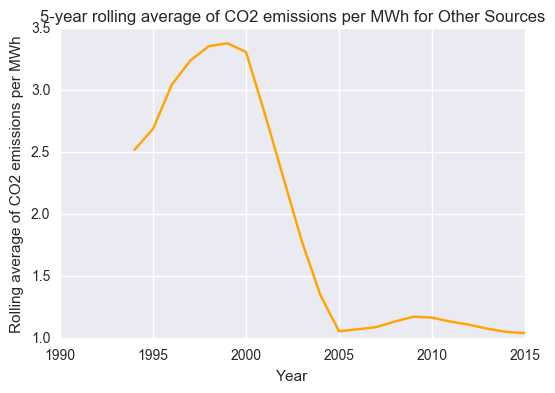

In [281]:
plt.figure(1) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Total"].co2permwh, window=5, freq='A').plot(color="green")
plt.title('5-year rolling average of CO2 emissions per MWh across all sources')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

plt.figure(2) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Coal"].co2permwh, window=5, freq='A').plot(color="black")
plt.title('5-year rolling average of CO2 emissions per MWh for Coal')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

plt.figure(3) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh, window=5, freq='A').plot(color="purple")
plt.title('5-year rolling average of CO2 emissions per MWh for Petroleum')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

plt.figure(4) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh, window=5, freq='A').plot(color="brown")
plt.title('5-year rolling average of CO2 emissions per MWh for Natural Gas')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

plt.figure(5) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh, window=5, freq='A').plot(color="magenta")
plt.title('5-year rolling average of CO2 emissions per MWh for Geothermal')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

plt.figure(6) 
pd.rolling_mean(ustotaldata[ustotaldata.Source=="Other"].co2permwh, window=5, freq='A').plot(color="orange")
plt.title('5-year rolling average of CO2 emissions per MWh for Other Sources')
plt.ylabel('Rolling average of CO2 emissions per MWh')
plt.xlabel('Year')

Plot rolling means against actual values to assess stationarity

/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
  from ipykernel import kernelapp as app
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window=5,center=False).mean()
/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(freq=A,window

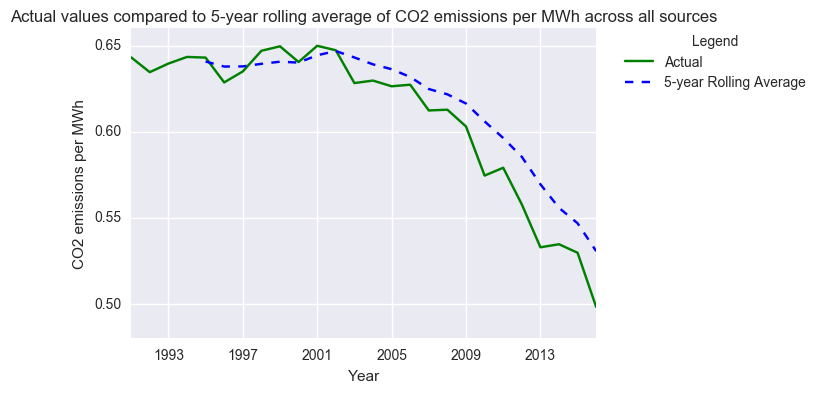

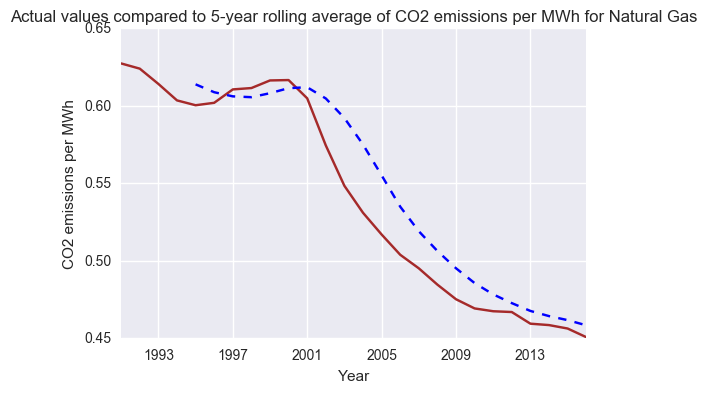

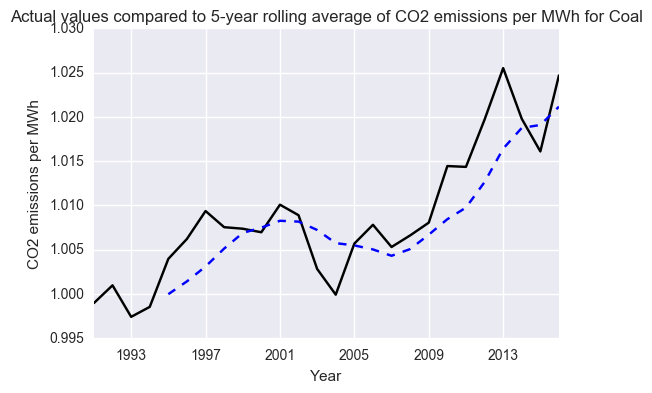

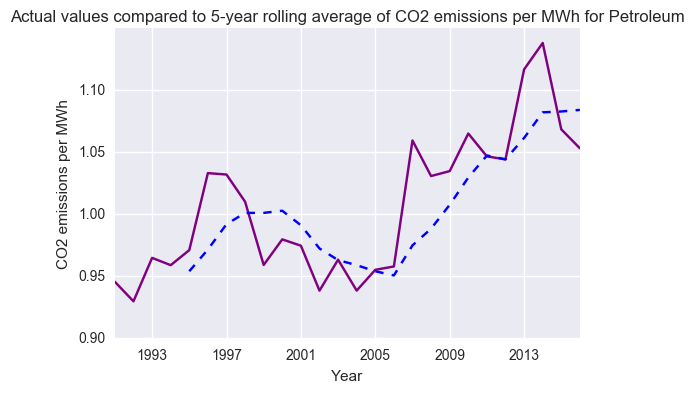

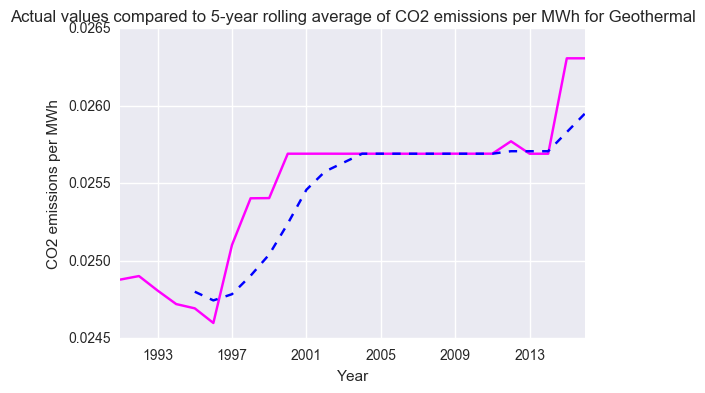

In [289]:
plt.figure(1)
rm_allsources = pd.rolling_mean(ustotaldata[ustotaldata.Source=="Total"].co2permwh, window=5, freq='A')
plt.plot(ustotaldata[ustotaldata.Source=="Total"].co2permwh, color="green")
plt.plot(rm_allsources, 'b--')
plt.title('Actual values compared to 5-year rolling average of CO2 emissions per MWh across all sources')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')
plt.legend(['Actual','5-year Rolling Average'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Legend')

plt.figure(2)
rm_natgas = pd.rolling_mean(ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh, window=5, freq='A')
plt.plot(ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh, color="brown")
plt.plot(rm_natgas, 'b--')
plt.title('Actual values compared to 5-year rolling average of CO2 emissions per MWh for Natural Gas')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')
#plt.legend(['Actual','5-year Rolling Average'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Legend')

plt.figure(3)
rm_coal = pd.rolling_mean(ustotaldata[ustotaldata.Source=="Coal"].co2permwh, window=5, freq='A')
plt.plot(ustotaldata[ustotaldata.Source=="Coal"].co2permwh, color="black")
plt.plot(rm_coal, 'b--')
plt.title('Actual values compared to 5-year rolling average of CO2 emissions per MWh for Coal')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')
#plt.legend(['Actual','5-year Rolling Average'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Legend')

plt.figure(4)
rm_petroleum = pd.rolling_mean(ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh, window=5, freq='A')
plt.plot(ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh, color="purple")
plt.plot(rm_petroleum, 'b--')
plt.title('Actual values compared to 5-year rolling average of CO2 emissions per MWh for Petroleum')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')
#plt.legend(['Actual','5-year Rolling Average'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Legend')

plt.figure(5)
rm_geothermal = pd.rolling_mean(ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh, window=5, freq='A')
plt.plot(ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh, color="magenta")
plt.plot(rm_geothermal, 'b--')
plt.title('Actual values compared to 5-year rolling average of CO2 emissions per MWh for Geothermal')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')
#plt.legend(['Actual','5-year Rolling Average'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Legend')



The above plot shows that the 5-year rolling average of CO2 emissions per MWh for All Sources is consistently higher than the actual values from 2002 going forward.

The above plot shows that the 5-year rolling average of CO2 emissions per MWh for Natural Gas is consistently higher than the actual values from 2001 going forward.

The above plot shows that the 5-year rolling average of CO2 emissions per MWh for Coal is consistently lower than the actual values from 2005 on, with the exception of 2014.

The above plot shows that the 5-year rolling average of CO2 emissions per MWh for Petroleum is consistently lower than the actual values from 2005 on, with the exception of 2014 and 2015.

The above plot shows that the 5-year rolling average of CO2 emissions per MWh for Geothermal is oddly the same as the the actual values from 2005 to 2013, with actual values going higher only 2014 and prior to 2005.

Create box plots that show the distribution of annual CO2 emissions per MWh (CO2 efficiency measure) amongst dirtiest energy sources of electricity generation (1990 to 2015).  This shows that the CO2 efficiency measure varies least over time for Coal and most for Other sources with Petroleum and Natural Gas showing the largest change in CO2 efficiency over time.

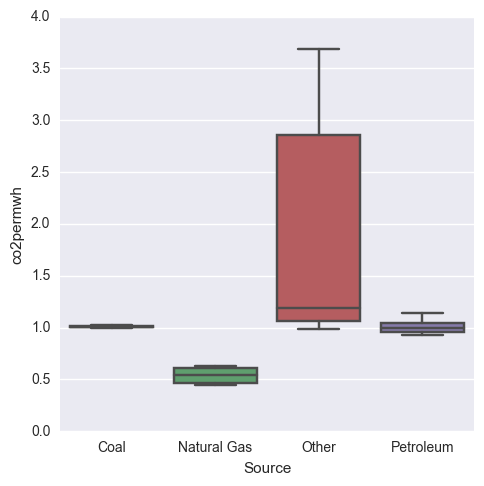

In [38]:
dirtysources = ustotaldata.loc[(ustotaldata['Source']=="Coal") | (ustotaldata['Source']=="Petroleum") | (ustotaldata['Source']=="Natural Gas") | (ustotaldata['Source']=="Other")]
dirtysources.tail(3)                                                                                                              
sns.factorplot(
    x='Source',
    y='co2permwh',
    data=dirtysources, 
    kind="box",
    size=5
)

Show year-over-year differences in Net Generation, CO2 emissions, CO2 emissions per MWh for each dirty source

In [39]:
print ustotaldata[ustotaldata.Source=="Total"]["co2"].diff(periods=1)

Date
1990-12-31            NaN
1991-12-31     -3233235.0
1992-12-31     21809402.0
1993-12-31     84777491.0
1994-12-31     31085801.0
1995-12-31     19867694.0
1996-12-31     78973546.0
1997-12-31     72341879.0
1998-12-31     92277997.0
1999-12-31     14702779.0
2000-12-31    104532149.0
2001-12-31    -52227722.0
2002-12-31      5356367.0
2003-12-31     21131210.0
2004-12-31     41887258.0
2005-12-31     56856605.0
2006-12-31    -54920412.0
2007-12-31     58114735.0
2008-12-31    -63020375.0
2009-12-31   -214504483.0
2010-12-31    119088287.0
2011-12-31   -101525185.0
2012-12-31   -130195953.0
2013-12-31     16931661.0
2014-12-31     -5522163.0
2015-12-31   -136832012.0
Name: co2, dtype: float64


Identify the years with largest year-over-year drop in CO2 emissions

In [40]:
ustotaldata['co2diff'] = ustotaldata[ustotaldata.Source=="Total"]["co2"].diff(periods=1)
ustotaldata[ustotaldata.Source=="Total"].sort_values(by='co2diff').head()

,Year,Source,co2,so2,nox,generation,Month,Day,co2permwh,so2permwh,noxpermwh,co2diff
Date,,,,,,,,,,,,
2009-12-31,2009,Total,2.269508e+09,5970324.0,2395450.0,3.950331e+09,12,31,0.574511,0.001511,0.000606,-214504483.0
2015-12-31,2015,Total,2.031452e+09,2547773.0,1824048.0,4.077601e+09,12,31,0.498198,0.000625,0.000447,-136832012.0
2012-12-31,2012,Total,2.156875e+09,3703970.0,2147726.0,4.047765e+09,12,31,0.532856,0.000915,0.000531,-130195953.0
2011-12-31,2011,Total,2.287071e+09,4844990.0,2406411.0,4.100141e+09,12,31,0.557803,0.001182,0.000587,-101525185.0
2008-12-31,2008,Total,2.484012e+09,7829798.0,3330223.0,4.119388e+09,12,31,0.603005,0.001901,0.000808,-63020375.0


Identify the years with largest year-over-year increases in CO2 emissions

In [41]:
ustotaldata[ustotaldata.Source=="Total"].sort_values(by='co2diff').tail()

,Year,Source,co2,so2,nox,generation,Month,Day,co2permwh,so2permwh,noxpermwh,co2diff
Date,,,,,,,,,,,,
1993-12-31,1993,Total,2.057053e+09,14965892.0,7996658.0,3.197191e+09,12,31,0.643394,0.004681,0.002501,84777491.0
1998-12-31,1998,Total,2.351600e+09,13464481.0,6458698.0,3.620295e+09,12,31,0.649560,0.003719,0.001784,92277997.0
2000-12-31,2000,Total,2.470834e+09,11903806.0,5638125.0,3.802105e+09,12,31,0.649860,0.003131,0.001483,104532149.0
2010-12-31,2010,Total,2.388596e+09,5400450.0,2491024.0,4.125060e+09,12,31,0.579045,0.001309,0.000604,119088287.0
1990-12-31,1990,Total,1.953699e+09,15461524.0,7961276.0,3.037827e+09,12,31,0.643124,0.005090,0.002621,NaN


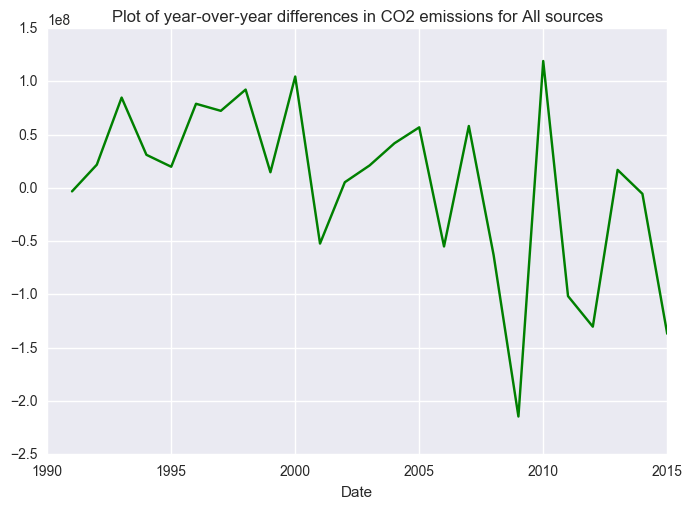

In [42]:
#Plot year-over-year differences in CO2 emissions for All sources
ustotaldata[ustotaldata.Source=="Total"]["co2"].diff(1).plot(color="green")
plt.title('Plot of year-over-year differences in CO2 emissions for All sources')

The above output shows that the largest year-over-year drops in absolute CO2 emissions for All Sources were observed in the more recent period: 2009 (214 million metric tons), 2015 (137 million metric tons), 2012 (130 million metric tons) and 2011 (101 million metric tons). Conversely, the largest year-over-year increases in absolute CO2 emissions for All Sources were observed during the decade of the 1990s, the year 2000 and 2010: 2010 (119 million metric tons), 2000 (104 million metric tons), 1998 (92 million metric tons) and 1993 (84 million metric tons).

In [43]:
print ustotaldata[ustotaldata.Source=="Total"]["generation"].diff(periods=1)

Date
1990-12-31             NaN
1991-12-31    3.597155e+07
1992-12-31    1.008332e+07
1993-12-31    1.133089e+08
1994-12-31    5.033129e+07
1995-12-31    1.059650e+08
1996-12-31    9.070026e+07
1997-12-31    4.798466e+07
1998-12-31    1.281232e+08
1999-12-31    7.451431e+07
2000-12-31    1.072952e+08
2001-12-31   -6.546139e+07
2002-12-31    1.218086e+08
2003-12-31    2.473295e+07
2004-12-31    8.737006e+07
2005-12-31    8.486749e+07
2006-12-31    9.279477e+06
2007-12-31    9.204250e+07
2008-12-31   -3.735696e+07
2009-12-31   -1.690568e+08
2010-12-31    1.747290e+08
2011-12-31   -2.491897e+07
2012-12-31   -5.237566e+07
2013-12-31    1.819880e+07
2014-12-31    2.764194e+07
2015-12-31   -1.600507e+07
Name: generation, dtype: float64


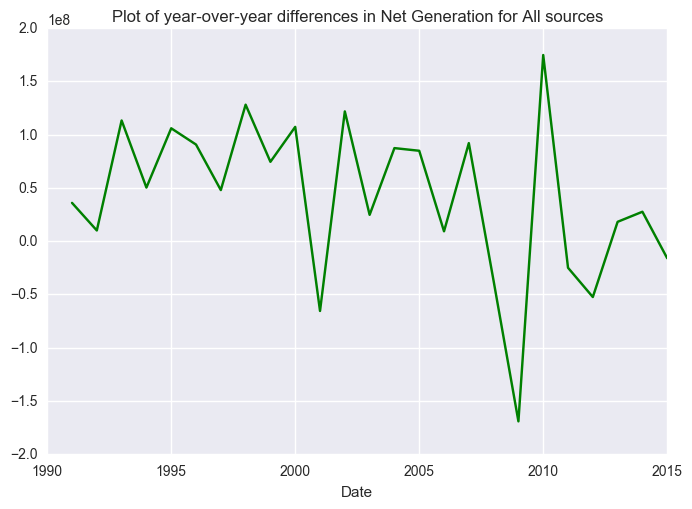

In [44]:
#Plot year-over-year differences in Net generation for All sources
ustotaldata[ustotaldata.Source=="Total"]["generation"].diff(1).plot(color="green")
plt.title('Plot of year-over-year differences in Net Generation for All sources')

The above output shows that the largest year-over-year drops in absolute net generation for All Sources were observed during periods of economic recessions or slow economic growth: 2009 (-1.69e+08 MWh), 2008 (-3.74e+07 MWh), 2012 (-5.24e+07 MWh) and 2001 (-6.55e+07 MWh). Conversely, the largest year-over-year increases in net generation for All Sources were observed following years of decreasing generation (2010 and 2002) and during the decade of the 1990s.

In [45]:
print ustotaldata[ustotaldata.Source=="Total"]["co2permwh"].diff(periods=1)

Date
1990-12-31         NaN
1991-12-31   -0.008578
1992-12-31    0.004997
1993-12-31    0.003851
1994-12-31   -0.000399
1995-12-31   -0.014393
1996-12-31    0.006376
1997-12-31    0.011990
1998-12-31    0.002593
1999-12-31   -0.009121
2000-12-31    0.009420
2001-12-31   -0.002592
2002-12-31   -0.019046
2003-12-31    0.001440
2004-12-31   -0.003306
2005-12-31    0.000912
2006-12-31   -0.014944
2007-12-31    0.000422
2008-12-31   -0.009742
2009-12-31   -0.028494
2010-12-31    0.004534
2011-12-31   -0.021242
2012-12-31   -0.024947
2013-12-31    0.001779
2014-12-31   -0.004959
2015-12-31   -0.031478
Name: co2permwh, dtype: float64


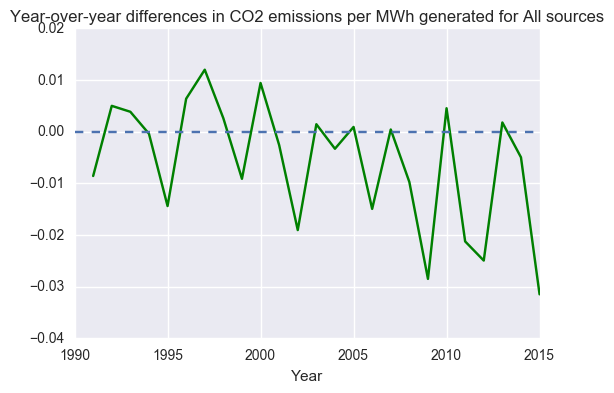

In [294]:
#Plot year-over-year differences in CO2 emissions per MWh generated for All sources
#Plot a zero line to demark increases and decreases
ustotaldata['zero'] = 0
ustotaldata[ustotaldata.Source=="Total"]["co2permwh"].diff(1).plot(color="green")
ustotaldata[ustotaldata.Source=="Total"]["zero"].plot(ls='--')
plt.title('Year-over-year differences in CO2 emissions per MWh generated for All sources')
plt.xlabel('Year')

The above output shows that the largest year-over-year drops in CO2 per MWh of electricity generated (CO2 emissions efficiency) for All Sources were observed in the more recent years: 2009 (-0.028 Metric Tons of CO2 per MWh), 2015 (-0.031 Metric Tons of CO2 per MWh), 2012 (-0.025 Metric Tons of CO2 per MWh) and 2011 (-0.021 Metric Tons of CO2 per MWh). Conversely, the largest year-over-year increases in CO2 per MWh of electricity generated for All Sources were observed during the 1990s and the year 2000.

Check autocorrelation across sources of CO2 emissions per MWh using past 10 lags

In [47]:
for i in range(1,11):
    print "Autocorrelation with lag of year", i
    print "Autocorrelation of CO2 per MWh for All Sources at sequential lags:", ustotaldata[ustotaldata.Source=="Total"].co2permwh.autocorr(lag=i)
    print "Autocorrelation of CO2 per MWh for Coal at sequential lags:", ustotaldata[ustotaldata.Source=="Coal"].co2permwh.autocorr(lag=i)
    print "Autocorrelation of CO2 per MWh for Petroleum at sequential lags:", ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh.autocorr(lag=i)
    print "Autocorrelation of CO2 per MWh for Natural Gas at sequential lags:", ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh.autocorr(lag=i)
    print "Autocorrelation of CO2 per MWh for Geothermal at sequential lags:", ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh.autocorr(lag=i)


Autocorrelation with lag of year 1
Autocorrelation of CO2 per MWh for All Sources at sequential lags: 0.968372804953
Autocorrelation of CO2 per MWh for Coal at sequential lags: 0.85830524624
Autocorrelation of CO2 per MWh for Petroleum at sequential lags: 0.781895575034
Autocorrelation of CO2 per MWh for Natural Gas at sequential lags: 0.990993910658
Autocorrelation of CO2 per MWh for Geothermal at sequential lags: 0.921110696581
Autocorrelation with lag of year 2
Autocorrelation of CO2 per MWh for All Sources at sequential lags: 0.949066600238
Autocorrelation of CO2 per MWh for Coal at sequential lags: 0.726925083125
Autocorrelation of CO2 per MWh for Petroleum at sequential lags: 0.601226312194
Autocorrelation of CO2 per MWh for Natural Gas at sequential lags: 0.966449853728
Autocorrelation of CO2 per MWh for Geothermal at sequential lags: 0.816959963801
Autocorrelation with lag of year 3
Autocorrelation of CO2 per MWh for All Sources at sequential lags: 0.950718299504
Autocorrelatio

Note above that All Sources, Natural Gas and Geothermal sources show strongest autocorrelation pattern using 10 lags. Coal shows strong autocorrelation pattern going back 4 to 5 years, but then drops off strongly after 5th year.

Petroleum shows no autocorrelation pattern.  Omit petroleum from Autoregressive modeling.

Plot autocorrelations for CO2 emitting sources 

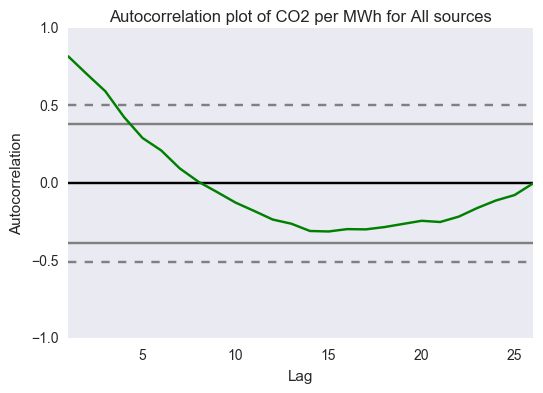

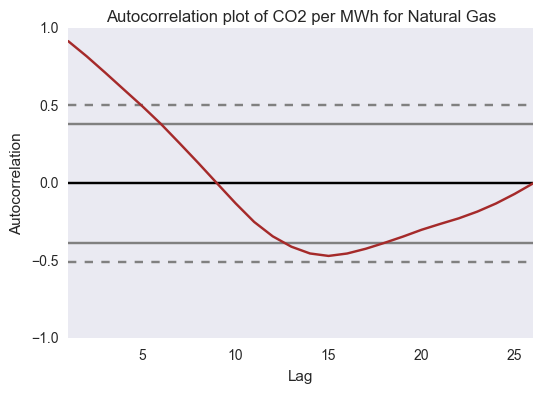

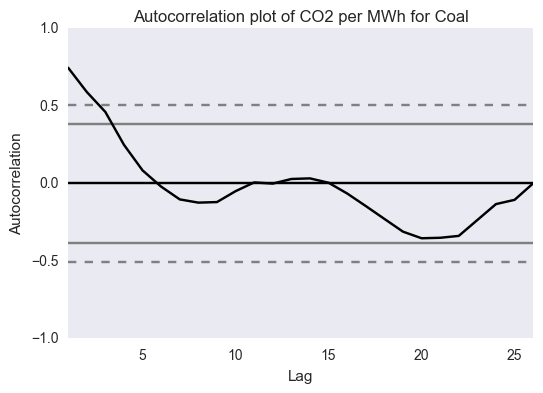

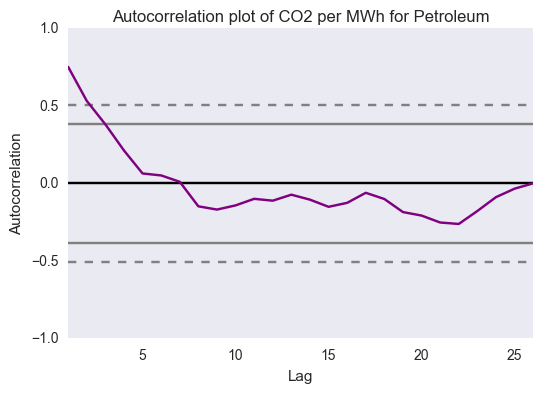

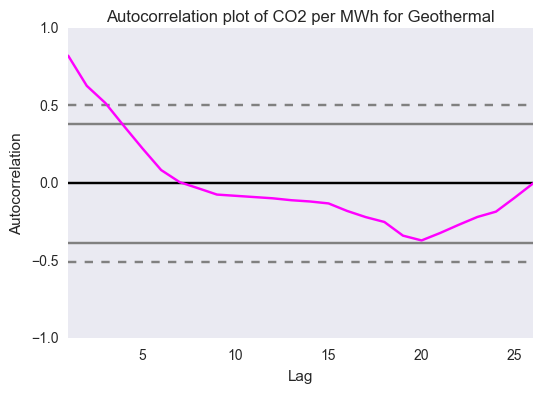

In [298]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(1)
autocorrelation_plot(ustotaldata[ustotaldata.Source=="Total"].co2permwh, color="green")
plt.title('Autocorrelation plot of CO2 per MWh for All sources')

plt.figure(2)
autocorrelation_plot(ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh, color="brown")
plt.title('Autocorrelation plot of CO2 per MWh for Natural Gas')

plt.figure(3)
autocorrelation_plot(ustotaldata[ustotaldata.Source=="Coal"].co2permwh, color="black")
plt.title('Autocorrelation plot of CO2 per MWh for Coal')

plt.figure(4)
autocorrelation_plot(ustotaldata[ustotaldata.Source=="Petroleum"].co2permwh, color="purple")
plt.title('Autocorrelation plot of CO2 per MWh for Petroleum')

plt.figure(5)
autocorrelation_plot(ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh, color="magenta")
plt.title('Autocorrelation plot of CO2 per MWh for Geothermal')

##### Plot autocorrelation plot with 10 lags

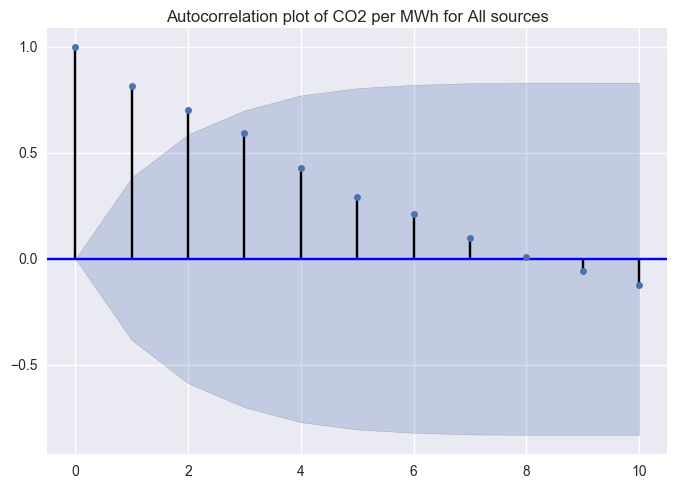

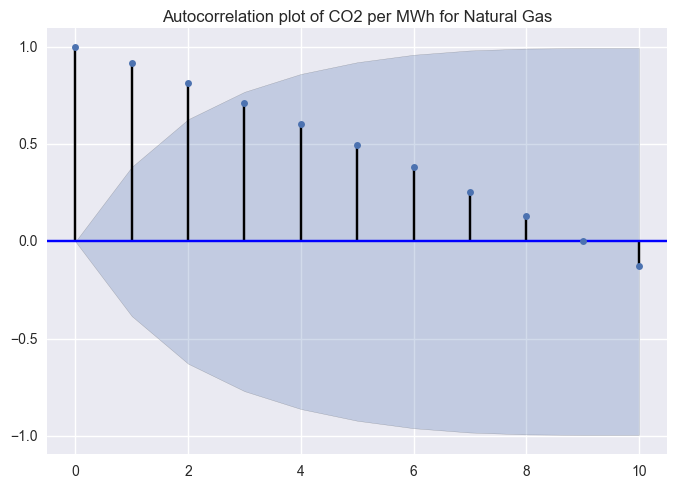

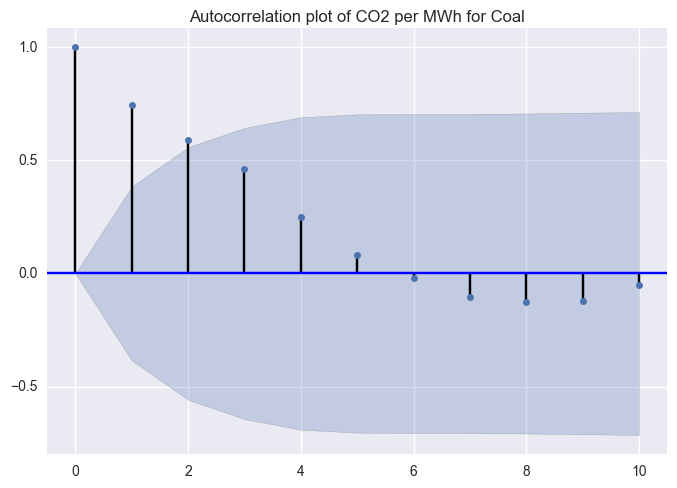

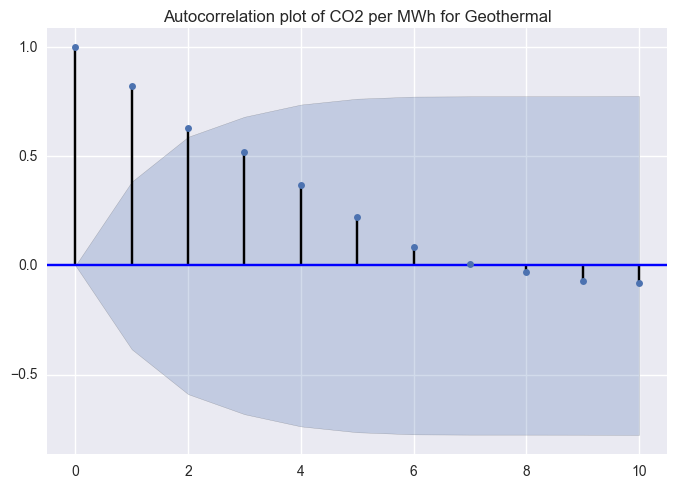

In [49]:
plt.figure(1)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ustotaldata[ustotaldata.Source=="Total"].co2permwh, lags=10)
plt.title('Autocorrelation plot of CO2 per MWh for All sources')

plt.figure(2)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ustotaldata[ustotaldata.Source=="Natural Gas"].co2permwh, lags=10)
plt.title('Autocorrelation plot of CO2 per MWh for Natural Gas')

plt.figure(3)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ustotaldata[ustotaldata.Source=="Coal"].co2permwh, lags=10)
plt.title('Autocorrelation plot of CO2 per MWh for Coal')

plt.figure(4)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ustotaldata[ustotaldata.Source=="Geothermal"].co2permwh, lags=10)
plt.title('Autocorrelation plot of CO2 per MWh for Geothermal')


Run Autoregressive model on All Sources, Natural Gas, Geothermal and Coal

In [303]:
allsources = ustotaldata[ustotaldata['Source']=="Total"]['co2permwh']
natgas = ustotaldata[ustotaldata['Source']=="Natural Gas"]['co2permwh']
geothermal = ustotaldata[ustotaldata['Source']=="Geothermal"]['co2permwh']
coal = ustotaldata[ustotaldata['Source']=="Coal"]['co2permwh']
petroleum = ustotaldata[ustotaldata['Source']=="Petroleum"]['co2permwh']

In [305]:
# Run ARMA (1,0) on All Sources data for all years 
from statsmodels.tsa.arima_model import ARMA
arma_allsources = ARMA(allsources, (1, 0)).fit()
arma_allsources.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  74.207
Method:                       css-mle   S.D. of innovations              0.013
Date:                Thu, 22 Dec 2016   AIC                           -142.414
Time:                        01:18:32   BIC                           -138.639
Sample:                    12-31-1990   HQIC                          -141.327
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.5786      0.061      9.555      0.000         0.460     0.697
ar.L1.co2permwh     0.9807      0.025     39.577      0.000         0.932     1.029
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0197           +0.0000j            1.0197            0.0000
-----------------------------------------------------------------------------
"""

In [306]:
# Run ARMA (1,0) on Natural Gas data for all years 
arma_natgas = ARMA(natgas, (1, 0)).fit()
arma_natgas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  77.844
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 22 Dec 2016   AIC                           -149.689
Time:                        01:19:01   BIC                           -145.914
Sample:                    12-31-1990   HQIC                          -148.602
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.5394      0.080      6.723      0.000         0.382     0.697
ar.L1.co2permwh     0.9912      0.012     82.608      0.000         0.968     1.015
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0089           +0.0000j            1.0089            0.0000
-----------------------------------------------------------------------------
"""

In [307]:
# Run ARMA (1,0) on Geothermal data for all years 
arma_geothermal = ARMA(geothermal, (1, 0)).fit()
arma_geothermal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                 185.793
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 22 Dec 2016   AIC                           -365.587
Time:                        01:21:42   BIC                           -361.812
Sample:                    12-31-1990   HQIC                          -364.500
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.0255      0.000     56.838      0.000         0.025     0.026
ar.L1.co2permwh     0.9488      0.056     16.846      0.000         0.838     1.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0540           +0.0000j            1.0540            0.0000
-----------------------------------------------------------------------------
"""

In [309]:
# Run ARMA (1,0) on Coal data for all years 
arma_coal = ARMA(coal, (1, 0)).fit()
arma_coal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                 106.374
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 22 Dec 2016   AIC                           -206.749
Time:                        01:23:58   BIC                           -202.975
Sample:                    12-31-1990   HQIC                          -205.662
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               1.0101      0.006    159.361      0.000         0.998     1.022
ar.L1.co2permwh     0.9080      0.087     10.414      0.000         0.737     1.079
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1013           +0.0000j            1.1013            0.0000
-----------------------------------------------------------------------------
"""

In [310]:
# Run ARMA (1,0) on Petroleum data for all years 
arma_petroleum = ARMA(petroleum, (1, 0)).fit()
arma_petroleum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  49.578
Method:                       css-mle   S.D. of innovations              0.035
Date:                Thu, 22 Dec 2016   AIC                            -93.156
Time:                        01:24:29   BIC                            -89.381
Sample:                    12-31-1990   HQIC                           -92.069
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               1.0051      0.028     36.385      0.000         0.951     1.059
ar.L1.co2permwh     0.7773      0.118      6.569      0.000         0.545     1.009
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2865           +0.0000j            1.2865            0.0000
-----------------------------------------------------------------------------
"""

Plot residuals to see if pattern is random or if there is some seasonality (and Moving Average model would be required)

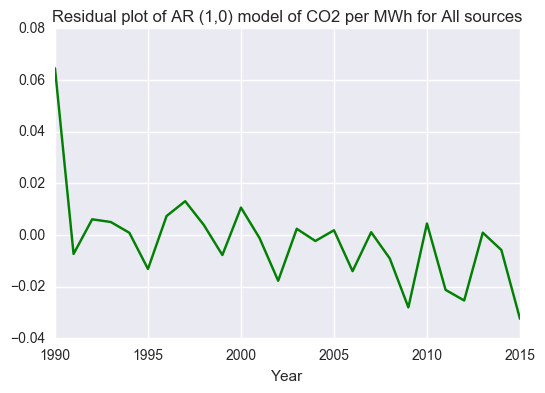

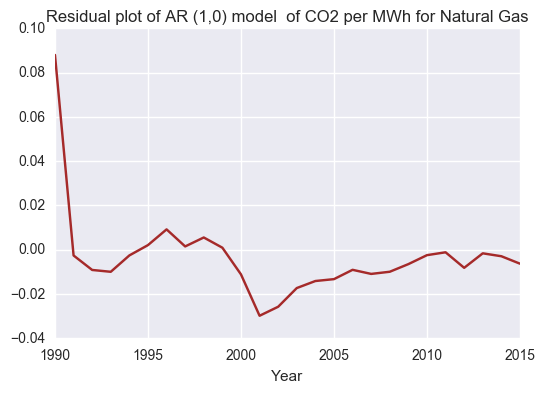

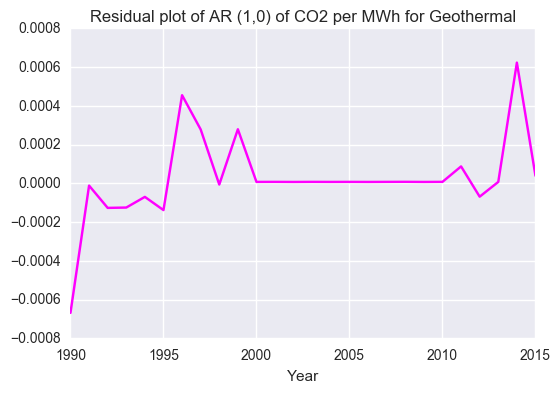

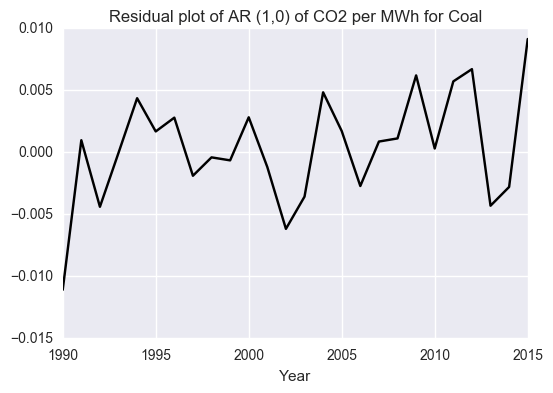

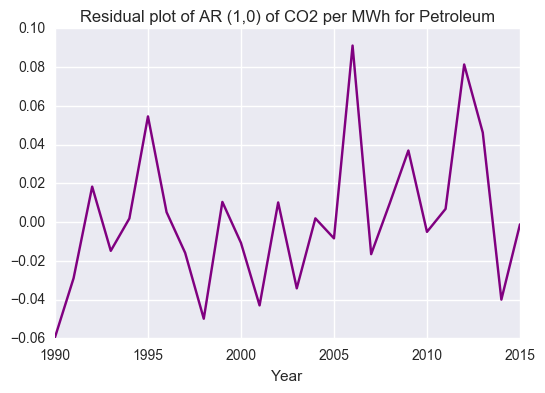

In [312]:
plt.figure(1)
arma_allsources.resid.plot(color="green")
plt.title('Residual plot of AR (1,0) model of CO2 per MWh for All sources')
plt.xlabel('Year')

plt.figure(2)
arma_natgas.resid.plot(color="brown")
plt.title('Residual plot of AR (1,0) model  of CO2 per MWh for Natural Gas')
plt.xlabel('Year')

plt.figure(3)
arma_geothermal.resid.plot(color="magenta")
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Geothermal')
plt.xlabel('Year')

plt.figure(4)
arma_coal.resid.plot(color="black")
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Coal')
plt.xlabel('Year')

plt.figure(5)
arma_petroleum.resid.plot(color="purple")
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Petroleum')
plt.xlabel('Year')

Residual plots of AR models indicate that residuals follow a random pattern for All Sources; however, residuals show some odd patterns with spikes for Natural Gas, Geothermal and Coal. For Natural Gas, particular concern around spike around 2001. For Geothermal, odd flat residuals between 2000 and 2010.  For Coal, there are some fluctuations, however, the scale is tight and we can say the residuals follow a random pattern.

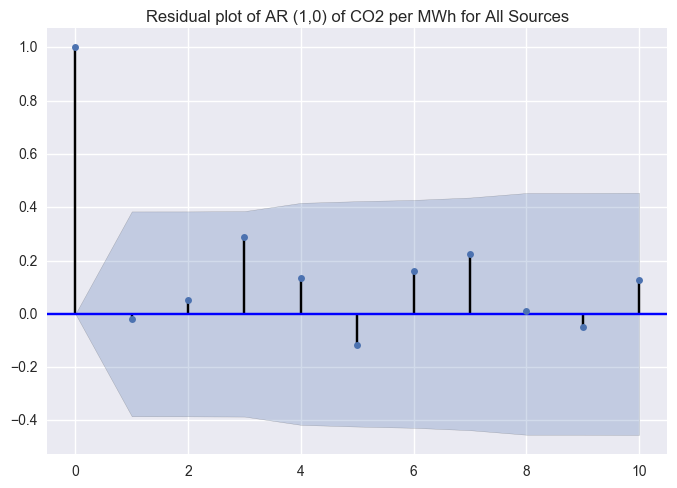

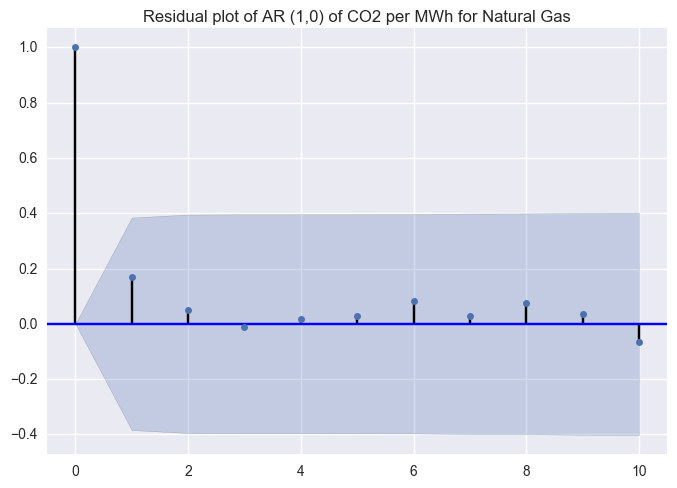

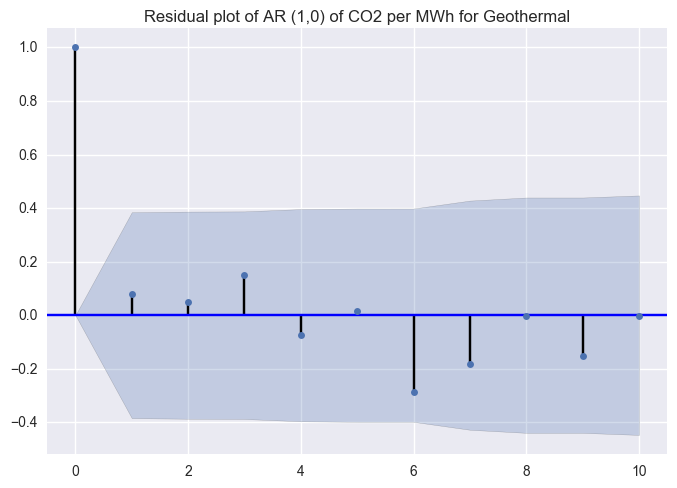

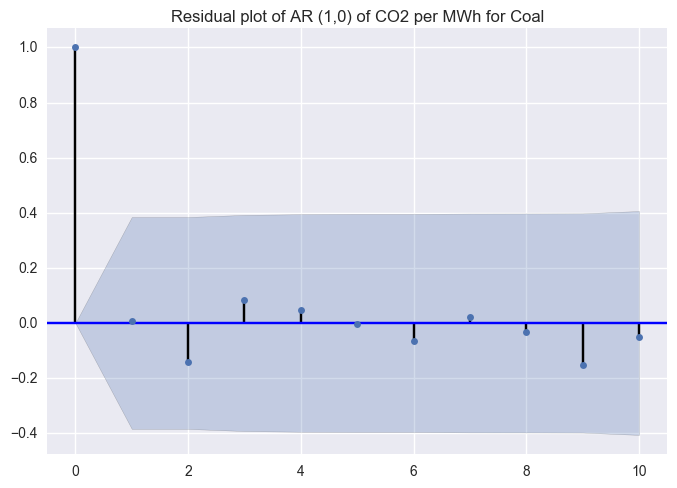

In [56]:
plt.figure(1)
plot_acf(arma_allsources.resid, lags=10)
plt.title('Residual plot of AR (1,0) of CO2 per MWh for All Sources')

plt.figure(2)
plot_acf(arma_natgas.resid, lags=10)
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Natural Gas')

plt.figure(3)
plot_acf(arma_geothermal.resid, lags=10)
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Geothermal')

plt.figure(4)
plot_acf(arma_coal.resid, lags=10)
plt.title('Residual plot of AR (1,0) of CO2 per MWh for Coal')


Given that the AR coefficients indicate non-stationarity, run Autoregressive Integrated Moving Average (ARIMA (1,1,1)) model to induce stationarity on All Sources, Natural Gas, Geothermal and Coal data

In [313]:
from statsmodels.tsa.arima_model import ARIMA
arima_allsources = ARIMA(allsources, (1, 1, 1)).fit()
arima_allsources.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  76.546
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 22 Dec 2016   AIC                           -145.093
Time:                        01:53:55   BIC                           -140.217
Sample:                    12-31-1991   HQIC                          -143.740
                         - 12-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0061      0.003     -2.345      0.028        -0.011    -0.001
ar.L1.D.co2permwh    -0.6808      0.194     -3.512      0.002        -1.061    -0.301
ma.L1.D.co2permwh     1.0000      0.522      1.915      0.069        -0.023     2.023
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4689           +0.0000j            1.4689            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

The ARIMA(1,1,1) model on All Sources indicates that forecasted 2016 value for CO2 emissions per MWh decreases by -.6808 from the 2015 value. The coefficient on MA is not significant and indicates that residuals are not large and influencing the results.

In [314]:
from statsmodels.tsa.arima_model import ARIMA
arima_natgas = ARIMA(natgas, (1, 1, 1)).fit()
arima_natgas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  93.433
Method:                       css-mle   S.D. of innovations              0.006
Date:                Thu, 22 Dec 2016   AIC                           -178.865
Time:                        02:00:16   BIC                           -173.990
Sample:                    12-31-1991   HQIC                          -177.513
                         - 12-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0067      0.003     -1.988      0.059        -0.013 -9.44e-05
ar.L1.D.co2permwh     0.5747      0.184      3.116      0.005         0.213     0.936
ma.L1.D.co2permwh     0.3418      0.188      1.819      0.083        -0.026     0.710
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7400           +0.0000j            1.7400            0.0000
MA.1           -2.9255           +0.0000j            2.9255            0.5000
-----------------------------------------------------------------------------
"""

The ARIMA(1,1,1) model on Natural Gas indicates that forecasted 2016 value for CO2 emissions per MWh increases by .5707 from the 2015 value. The coefficient on MA is not significant at the 5% p-value level and indicates that residuals are not large and influencing the results.

In [317]:
from statsmodels.tsa.arima_model import ARIMA
arima_geothermal = ARIMA(geothermal, (1, 0, 1)).fit()
arima_geothermal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   26
Model:                     ARMA(1, 1)   Log Likelihood                 186.191
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 22 Dec 2016   AIC                           -364.381
Time:                        02:02:47   BIC                           -359.349
Sample:                    12-31-1990   HQIC                          -362.932
                         - 12-31-2015                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.0255      0.000     67.604      0.000         0.025     0.026
ar.L1.co2permwh     0.9160      0.094      9.765      0.000         0.732     1.100
ma.L1.co2permwh     0.2164      0.270      0.801      0.431        -0.313     0.746
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0917           +0.0000j            1.0917            0.0000
MA.1           -4.6211           +0.0000j            4.6211            0.5000
-----------------------------------------------------------------------------
"""

For Geothermal energy, given the constant CO2 emissions per MWh observed between 1999 and 2010, detrending is not required to perform the ARIMA on the entire 25 year history.  This is despite, the increasing trend in CO2 emissions per MWh observed for Geothermal since 2010. Therefore, an ARIMA (1,0,1) or ARMA model is applied for the Geothermal. 

The ARIMA(1,0,1) model on Geothermal indicates that forecasted 2016 value for CO2 emissions per MWh increases by .916 from the 2015 value. The coefficient on MA is not significant and indicates that residuals are not large and influencing the results.

In [318]:
from statsmodels.tsa.arima_model import ARIMA
arima_coal = ARIMA(coal, (1, 1, 1)).fit()
arima_coal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 104.839
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 22 Dec 2016   AIC                           -201.678
Time:                        02:08:49   BIC                           -196.802
Sample:                    12-31-1991   HQIC                          -200.325
                         - 12-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0011      0.001      1.294      0.209        -0.001     0.003
ar.L1.D.co2permwh    -0.6788      0.184     -3.689      0.001        -1.040    -0.318
ma.L1.D.co2permwh     1.0000      0.145      6.899      0.000         0.716     1.284
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4731           +0.0000j            1.4731            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

The ARIMA(1,1,1) model on Coal indicates that forecasted 2016 value for CO2 emissions per MWh decreases by -.6788 from the 2015 value. The coefficient on MA is significant and indicates that residuals can be influencing the results. 

As a test, run ARIMA(1,1,2) below on the Coal data to observe impact of second order of the MA component on the coefficients. 

In [324]:
from statsmodels.tsa.arima_model import ARIMA
arima_coal_secondma = ARIMA(coal, (1, 1, 2)).fit()
arima_coal_secondma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   25
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 106.475
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 22 Dec 2016   AIC                           -202.950
Time:                        02:23:04   BIC                           -196.856
Sample:                    12-31-1991   HQIC                          -201.260
                         - 12-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0009      0.000      4.603      0.000         0.001     0.001
ar.L1.D.co2permwh     0.3567      0.259      1.380      0.182        -0.150     0.863
ma.L1.D.co2permwh    -0.3931      0.259     -1.518      0.144        -0.901     0.115
ma.L2.D.co2permwh    -0.6069      0.229     -2.652      0.015        -1.056    -0.158
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8032           +0.0000j            2.8032            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6476           +0.0000j            1.6476            0.5000
-----------------------------------------------------------------------------
"""

In [326]:
from statsmodels.tsa.arima_model import ARIMA
arima_petroleum = ARIMA(petroleum, (2, 1, 1)).fit()
arima_petroleum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   25
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  47.952
Method:                       css-mle   S.D. of innovations              0.035
Date:                Thu, 22 Dec 2016   AIC                            -85.905
Time:                        02:45:22   BIC                            -79.810
Sample:                    12-31-1991   HQIC                           -84.214
                         - 12-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0053      0.005      1.135      0.269        -0.004     0.014
ar.L1.D.co2permwh    -0.0016      0.955     -0.002      0.999        -1.873     1.869
ar.L2.D.co2permwh    -0.2606      0.280     -0.930      0.363        -0.809     0.288
ma.L1.D.co2permwh    -0.1963      1.001     -0.196      0.846        -2.158     1.765
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0030           -1.9590j            1.9590           -0.2502
AR.2           -0.0030           +1.9590j            1.9590            0.2502
MA.1            5.0941           +0.0000j            5.0941            0.0000
-----------------------------------------------------------------------------
"""

The ARIMA (1,1,2) model on the Coal data indicates that the AR coefficient becomes insignificant when including a second order MA component. The coefficient on first order MA becomes insignificant, yet the coefficient on the second order MA indicates that residuals can be influencing the results. 


Plot the residuals on the ARIMA models above to see if pattern of residuals becomes random compared to residual plots on ARMA (1,0). Observe if spikes in residuals go away.

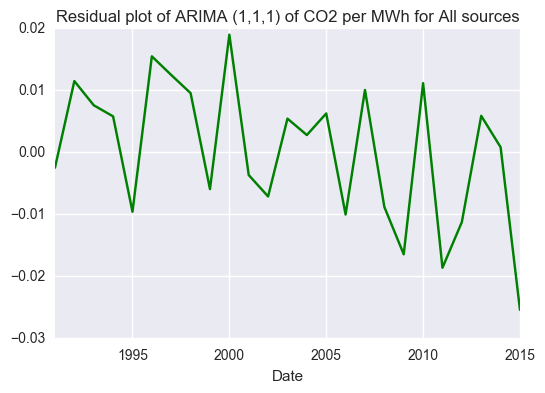

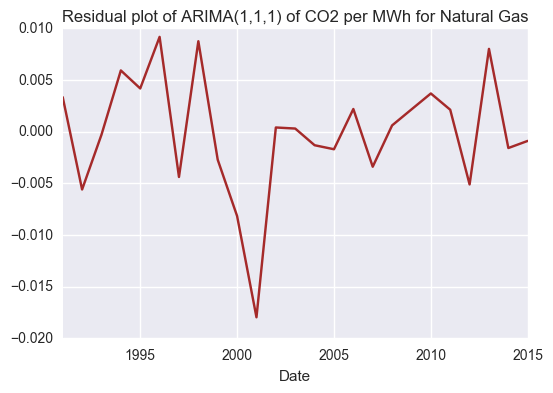

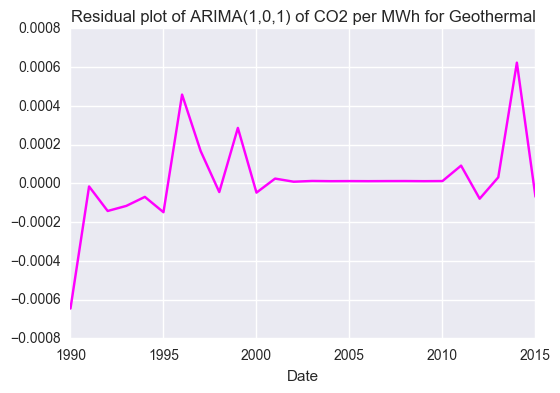

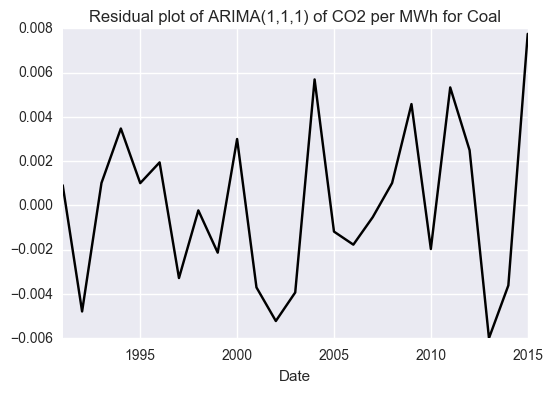

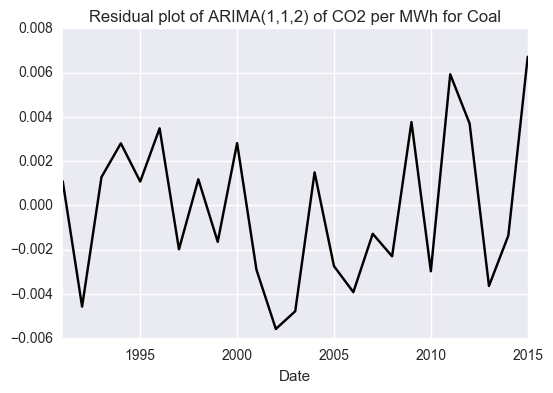

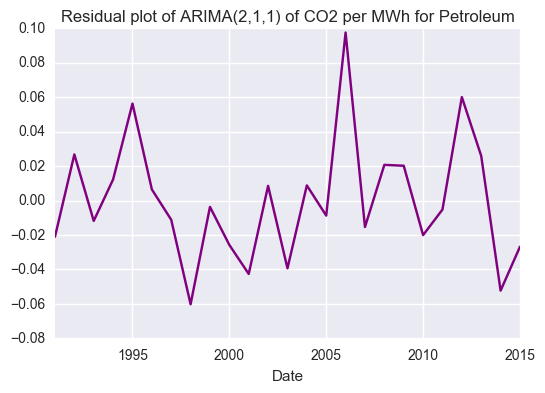

In [328]:
plt.figure(1)
arima_allsources.resid.plot(color="green")
plt.title('Residual plot of ARIMA (1,1,1) of CO2 per MWh for All sources')

plt.figure(2)
arima_natgas.resid.plot(color="brown")
plt.title('Residual plot of ARIMA(1,1,1) of CO2 per MWh for Natural Gas')

plt.figure(3)
arima_geothermal.resid.plot(color="magenta")
plt.title('Residual plot of ARIMA(1,0,1) of CO2 per MWh for Geothermal')

plt.figure(4)
arima_coal.resid.plot(color="black")
plt.title('Residual plot of ARIMA(1,1,1) of CO2 per MWh for Coal')

plt.figure(5)
arima_coal_secondma.resid.plot(color="black")
plt.title('Residual plot of ARIMA(1,1,2) of CO2 per MWh for Coal')

plt.figure(6)
arima_petroleum.resid.plot(color="purple")
plt.title('Residual plot of ARIMA(2,1,1) of CO2 per MWh for Petroleum')

Residual plots of ARIMA models indicate that residuals follow a random pattern for All Sources; however, residuals show some odd patterns with spikes for Natural Gas, Geothermal and Coal. For Natural Gas, the particular concern is around the downward spike in residuals around 2001, although the residual trend is random thereafter. For Geothermal, odd flat residuals between 2001 and 2010.  For Coal, there are fluctuations in both directions, using both the ARIMA (1,1,1) and ARIMA(1,1,2) models.

Predict next 5 years of CO2 emission per MWh of electricity generated for All Sources using all 25 years of history

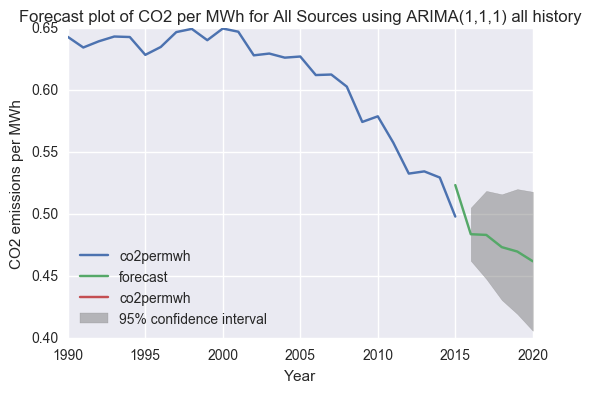

In [342]:
fig, ax = plt.subplots()
ax = allsourcesdata.plot(ax=ax)
fig = arima_allsources.plot_predict(25, 30, ax=ax, plot_insample=True)
plt.title('Forecast plot of CO2 per MWh for All Sources using ARIMA(1,1,1) all history')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')

Show All Sources ARIMA(1,1,1) prediction values

In [353]:
print arima_allsources.arparams
print arima_allsources.maparams

predictions_arima_allsources = pd.Series(arima_allsources.fittedvalues, copy=True)
print predictions_arima_allsources.tail(6)
#print arima_allsources.predict()
print allsources.diff(periods=1).tail(6)



[-0.68077148]
[ 0.99999974]
Date
2010-12-31   -0.006621
2011-12-31   -0.002627
2012-12-31   -0.013699
2013-12-31   -0.004106
2014-12-31   -0.005788
2015-12-31   -0.006078
dtype: float64
Date
2010-12-31    0.004534
2011-12-31   -0.021242
2012-12-31   -0.024947
2013-12-31    0.001779
2014-12-31   -0.004959
2015-12-31   -0.031478
Name: co2permwh, dtype: float64


Compare All Sources ARIMA prediction values to actual values.  
First, add the differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. 

Next, add the cumulative values to the base number. Create a series with all values as base number and add the differences to it.

In [356]:
#Take cumulative sum of predicted differences
predictions_arima_allsources_cumsum = predictions_arima_allsources.cumsum()
print predictions_arima_allsources_cumsum.head()

#Add cumulative values to the base number
predictions_arima_allsources = pd.Series(allsourcesdata['co2permwh'].ix[0], index=allsourcesdata.index)
predictions_arima_allsources = predictions_arima_allsources.add(predictions_arima_allsources_cumsum,fill_value=0)
print predictions_arima_allsources.tail()


Date
1991-12-31   -0.006101
1992-12-31   -0.012597
1993-12-31   -0.016342
1994-12-31   -0.022541
1995-12-31   -0.027349
dtype: float64
Date
2011-12-31    0.523383
2012-12-31    0.509684
2013-12-31    0.505578
2014-12-31    0.499790
2015-12-31    0.493712
dtype: float64


Compare All Sources ARIMA predicted values to actual values for last five years (2011-2015) 

In [341]:
years = ['2010', '2011', '2012','2013','2014','2015']
for year in years:
    
    print 'Predictions for Year:', year
    print 'Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on All Sources:', predictions_arima_allsources[year]
    print 'Actual CO2 emissions per MWh on All Sources:', allsourcesdata.co2permwh[year]
    print 'Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on All Sources:', predictions_arima_allsources[year] - allsourcesdata.co2permwh[year]

Predictions for Year: 2010
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on All Sources: Date
2010-12-31    0.526011
dtype: float64
Actual CO2 emissions per MWh on All Sources: Date
2010-12-31    0.579045
Name: co2permwh, dtype: float64
Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on All Sources: Date
2010-12-31   -0.053034
dtype: float64
Predictions for Year: 2011
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on All Sources: Date
2011-12-31    0.523383
dtype: float64
Actual CO2 emissions per MWh on All Sources: Date
2011-12-31    0.557803
Name: co2permwh, dtype: float64
Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on All Sources: Date
2011-12-31   -0.03442
dtype: float64
Predictions for Year: 2012
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on All Sources: Date
2012-12-31    0.509684
dtype: float64
Actual CO2 emissions per MWh on All Sources: Date
2012-1

Predict next 5 years of CO2 emission per MWh of electricity generated for Natural Gas (using all 25 years of history)

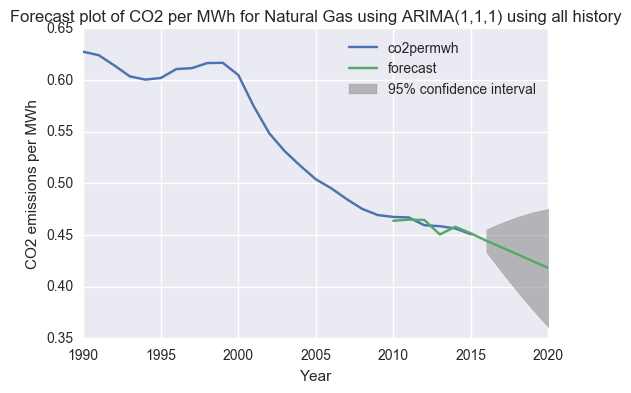

In [355]:
fig, ax = plt.subplots()
ax = natgasdata.plot(ax=ax)
fig = arima_natgas.plot_predict(20, 30, ax=ax, plot_insample=False)
plt.title('Forecast plot of CO2 per MWh for Natural Gas using ARIMA(1,1,1) using all history')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')

Show Natural Gas ARIMA(1,1,1) prediction values

In [358]:
print arima_natgas.arparams
print arima_natgas.maparams

predictions_arima_natgas = pd.Series(arima_natgas.fittedvalues, copy=True)
print predictions_arima_natgas.head()
#print arima_allsources.predict()

[ 0.57470396]
[ 0.34181961]
Date
1991-12-31   -0.006696
1992-12-31   -0.004271
1993-12-31   -0.010315
1994-12-31   -0.009047
1995-12-31   -0.002618
dtype: float64


Compare Natural Gas ARIMA prediction values to actual values.  

In [359]:
#Take cumulative sum of predicted differences
predictions_arima_natgas_cumsum = predictions_arima_natgas.cumsum()
print predictions_arima_natgas_cumsum.head()

#Add cumulative values to the base number
predictions_arima_natgas = pd.Series(natgasdata['co2permwh'].ix[0], index=natgasdata.index)
predictions_arima_natgas = predictions_arima_natgas.add(predictions_arima_natgas_cumsum,fill_value=0)
print predictions_arima_natgas.tail()
print natgas.tail()

Date
1991-12-31   -0.006696
1992-12-31   -0.010967
1993-12-31   -0.021282
1994-12-31   -0.030329
1995-12-31   -0.032948
dtype: float64
Date
2011-12-31    0.469653
2012-12-31    0.467240
2013-12-31    0.458326
2014-12-31    0.457697
2015-12-31    0.453036
dtype: float64
Date
2011-12-31    0.466968
2012-12-31    0.459449
2013-12-31    0.458546
2014-12-31    0.456334
2015-12-31    0.450779
Name: co2permwh, dtype: float64


Compare Natural Gas ARIMA (1,1,1) predicted values to actual values for last five years (2011-2015)

In [360]:
years = ['2011', '2012','2013','2014','2015']
for year in years:
    
    print 'Predictions for Year:', year
    print 'Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on Natural Gas:', predictions_arima_natgas[year]
    print 'Actual CO2 emissions per MWh on Natural Gas:', natgasdata.co2permwh[year]
    print 'Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on Natural Gas:', predictions_arima_natgas[year] - natgasdata.co2permwh[year]

Predictions for Year: 2011
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on Natural Gas: Date
2011-12-31    0.469653
dtype: float64
Actual CO2 emissions per MWh on Natural Gas: Date
2011-12-31    0.466968
Name: co2permwh, dtype: float64
Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on Natural Gas: Date
2011-12-31    0.002685
dtype: float64
Predictions for Year: 2012
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on Natural Gas: Date
2012-12-31    0.46724
dtype: float64
Actual CO2 emissions per MWh on Natural Gas: Date
2012-12-31    0.459449
Name: co2permwh, dtype: float64
Difference between predicted CO2 emissions per MWh from ARIMA (1,1,1) model and actual values on Natural Gas: Date
2012-12-31    0.00779
dtype: float64
Predictions for Year: 2013
Predicted CO2 emissions per MWh from ARIMA (1,1,1) model on Natural Gas: Date
2013-12-31    0.458326
dtype: float64
Actual CO2 emissions per MWh on Natural Gas: Date
2013-12

Perform cross-validation of ARIMA (1,1,1) model on All Sources data  

First, split the All Sources time series between a training set and test set

As a test, set the training set to data prior to 2005 and test on post-2005 data

In [363]:
n = len(allsources)
print n #n_allsources gives 26 values

#Given that n_allsources gives 26 values, assign training set to the first 60% of values to get data prior to 2005
allsources_train = allsources[:int(.6*n)]
print allsources_train.tail(1)
#Given that n_allsources gives 26 values, assign test set to the latter 40% of values to get data after and including to 2005
allsources_test = allsources[int(.6*n):]
print allsources_test.tail(1)

26
Date
2004-12-31    0.626356
Name: co2permwh, dtype: float64
Date
2015-12-31    0.498198
Name: co2permwh, dtype: float64


Create an ARMA(1,0) model on the training data and compute the mean absolute error of the predictions

In [81]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [98]:
arma_allsources = sm.tsa.ARMA(allsources_train, (1, 0)).fit()

pred_arma_allsources = arma_allsources.predict(
    '2000-12-31',
    '2010-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arma_allsources))
arma_allsources.summary()

('Mean absolute error: ', 0.069531055611331521)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   15
Model:                     ARMA(1, 0)   Log Likelihood                  52.419
Method:                       css-mle   S.D. of innovations              0.007
Date:                Tue, 20 Dec 2016   AIC                            -98.837
Time:                        21:37:29   BIC                            -96.713
Sample:                    12-31-1990   HQIC                           -98.860
                         - 12-31-2004                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.6387      0.003    218.474      0.000         0.633     0.644
ar.L1.co2permwh     0.3751      0.255      1.473      0.165        -0.124     0.874
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6662           +0.0000j            2.6662            0.0000
-----------------------------------------------------------------------------
"""

The AR coefficient is insignificant and less than zero indicating that the data is stationary and de-trending is not required using the training set for years prior to 2005.  Therefore, the trend of CO2 per MWh using data prior to 2005 is not a good predictor on the test set. 

However, we can be reasonably satisfied with the mean absolute error of .0695.

As an experiment, run the ARMA (2,0) on the training set to see if AR coefficients becomes significant.

In [100]:
arma20_allsources = sm.tsa.ARMA(allsources_train, (2, 0)).fit()

pred_arma20_allsources = arma20_allsources.predict(
    '2000-12-31',
    '2010-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arma_allsources))
arma20_allsources.summary()

('Mean absolute error: ', 0.069531055611331521)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   15
Model:                     ARMA(2, 0)   Log Likelihood                  53.019
Method:                       css-mle   S.D. of innovations              0.007
Date:                Tue, 20 Dec 2016   AIC                            -98.038
Time:                        21:47:12   BIC                            -95.206
Sample:                    12-31-1990   HQIC                           -98.069
                         - 12-31-2004                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.6393      0.002    289.226      0.000         0.635     0.644
ar.L1.co2permwh     0.4632      0.260      1.780      0.100        -0.047     0.973
ar.L2.co2permwh    -0.3031      0.267     -1.134      0.279        -0.827     0.221
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7641           -1.6479j            1.8164           -0.1809
AR.2            0.7641           +1.6479j            1.8164            0.1809
-----------------------------------------------------------------------------
"""

The AR coefficients continue to be insignificant and less than one indicating using the training set for years prior to 2005 continues to be not a good predictor of test data after 2005.
However, we can be reasonably satisfied with the mean absolute error of .0695.

Attempt ARIMA using post-2002 to 2012 data as the training set.  Test set on years 2013 to 2015.

In [438]:
#Assign training set to values between years 2002 and 2013
allsources_train = allsources['2002':'2012']
print allsources_train.head(1)
print allsources_train.tail(1)
#Assign test set to years 2013 to 2015
allsources_test = allsources['2013':]
print allsources_test.tail(2)

Date
2002-12-31    0.628222
Name: co2permwh, dtype: float64
Date
2012-12-31    0.532856
Name: co2permwh, dtype: float64
Date
2014-12-31    0.529676
2015-12-31    0.498198
Name: co2permwh, dtype: float64


Test performance of training set using data post-2002 on All Sources using the AR(1) model.

In [439]:
from statsmodels.tsa.arima_model import ARIMA
arima100_allsources = sm.tsa.ARIMA(allsources_train, (1, 0, 0)).fit()

pred_arima100_allsources = arima100_allsources.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arima100_allsources))
arima100_allsources.summary()

('Mean absolute error: ', 0.013205621240532336)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   11
Model:                     ARMA(1, 0)   Log Likelihood                  20.269
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 22 Dec 2016   AIC                            -34.539
Time:                        15:57:21   BIC                            -33.345
Sample:                    12-31-2002   HQIC                           -35.291
                         - 12-31-2012                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.8432        nan        nan        nan           nan       nan
ar.L1.co2permwh     1.0000        nan        nan        nan           nan       nan
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

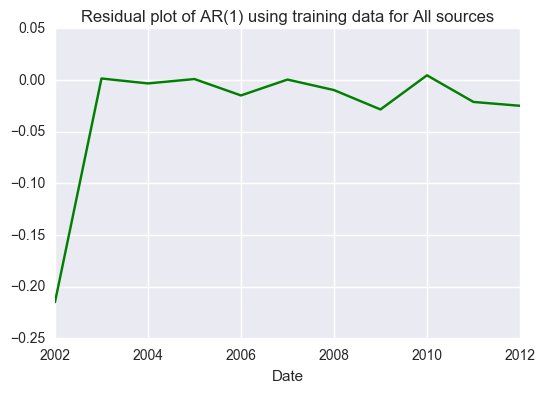

In [441]:
#Evaluate residuals to see if Moving Average model is required
plt.figure(1)
arima100_allsources.resid.plot(color="green")
plt.title('Residual plot of AR(1) using training data for All sources')

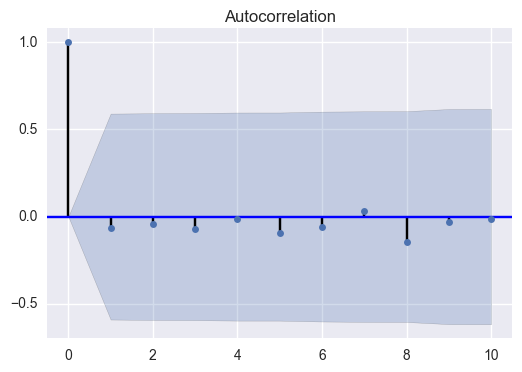

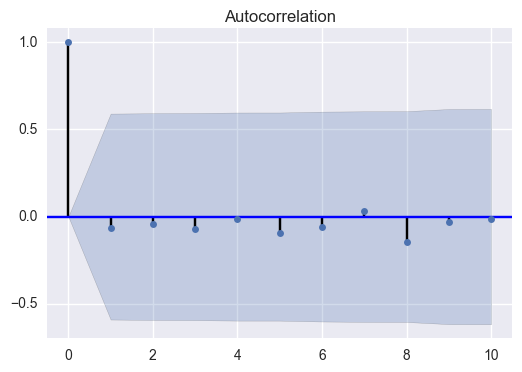

In [427]:
#Plot autocorrelation plots of the residuals
plot_acf(arima100_allsources.resid, lags=10)

The AR coefficient is equal to one indicating that the training set for years post-2002 is not stationary and is a good predictor of test data after 2013.  Need to re-run with detrending.  Moreover, the residual plot depicts several kinks and so warrants a Moving Average model.

We can be reasonably satisfied with the mean absolute error of .0132.

Run ARIMA (1,1,1) model on the post-2002 training dataset for All Sources

In [399]:
from statsmodels.tsa.arima_model import ARIMA
arima111_allsources = sm.tsa.ARIMA(allsources_train, (1, 1, 1)).fit()

pred_arima111_allsources = arima100_allsources.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arima111_allsources))
arima111_allsources.summary()

('Mean absolute error: ', 0.013205621240532336)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  30.687
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 22 Dec 2016   AIC                            -53.374
Time:                        14:52:08   BIC                            -52.163
Sample:                    12-31-2003   HQIC                           -54.701
                         - 12-31-2012                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0095      0.002     -4.282      0.004        -0.014    -0.005
ar.L1.D.co2permwh     0.7491      0.409      1.833      0.109        -0.052     1.550
ma.L1.D.co2permwh    -1.0000      0.265     -3.769      0.007        -1.520    -0.480
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3350           +0.0000j            1.3350            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

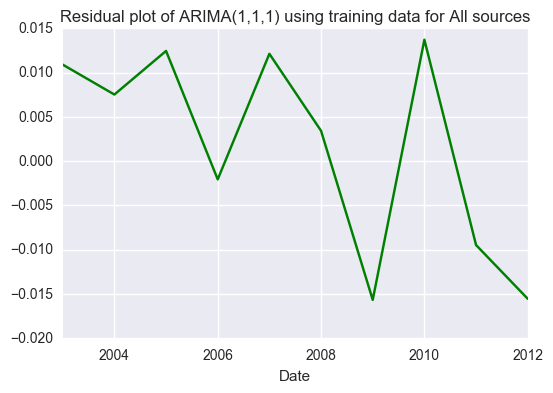

In [440]:
#Plot residuals for ARIMA(1,1,1)
plt.figure(1)
arima111_allsources.resid.plot(color="green")
plt.title('Residual plot of ARIMA(1,1,1) using training data for All sources')

The above ARIMA(1,1,1) model on the post-2002 training set is not predictive. The AR(1) coefficient is insignificant and the MA(1) coefficient is significant, indicating residuals are influential. Note the particularly large spike in 2009. We can be reasonably satisfied with the mean absolute error of .0132. 

Attempt different ARIMA models to attempt to remove autocorrelation in the residuals and produce a significant AR coefficient.  

In [421]:
#Run ARIMA (1,1,2)
from statsmodels.tsa.arima_model import ARIMA
arima112_allsources = sm.tsa.ARIMA(allsources_train, (1, 1, 2)).fit()

pred_arima112_allsources = arima112_allsources.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arima112_allsources))
arima112_allsources.summary()

('Mean absolute error: ', 0.52249932522755616)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   10
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  30.778
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 22 Dec 2016   AIC                            -51.556
Time:                        15:17:44   BIC                            -50.043
Sample:                    12-31-2003   HQIC                           -53.216
                         - 12-31-2012                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0091      0.001     -6.685      0.001        -0.012    -0.006
ar.L1.D.co2permwh    -0.2247      0.372     -0.604      0.568        -0.954     0.505
ma.L1.D.co2permwh  1.368e-07      0.709   1.93e-07      1.000        -1.389     1.389
ma.L2.D.co2permwh    -1.0000      0.709     -1.411      0.208        -2.389     0.389
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.4503           +0.0000j            4.4503            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

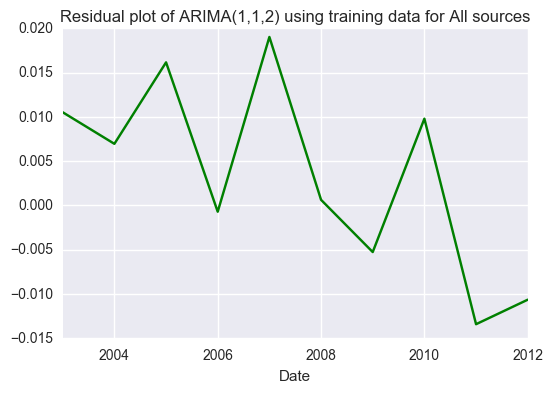

In [442]:
#Plot residuals for ARIMA(1,1,2)
plt.figure(1)
arima112_allsources.resid.plot(color="green")
plt.title('Residual plot of ARIMA(1,1,2) using training data for All sources')

In [423]:
#Run ARIMA (1,1,0) model
from statsmodels.tsa.arima_model import ARIMA
arima110_allsources = sm.tsa.ARIMA(allsources_train, (1, 1, 0)).fit()

pred_arima110_allsources = arima110_allsources.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(allsources_test, pred_arima110_allsources))
arima110_allsources.summary()

('Mean absolute error: ', 0.52940831618209883)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   10
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  30.619
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 22 Dec 2016   AIC                            -55.238
Time:                        15:18:43   BIC                            -54.330
Sample:                    12-31-2003   HQIC                           -56.233
                         - 12-31-2012                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0095      0.003     -3.133      0.014        -0.015    -0.004
ar.L1.D.co2permwh    -0.2051      0.339     -0.606      0.562        -0.869     0.459
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.8750           +0.0000j            4.8750            0.5000
-----------------------------------------------------------------------------
"""

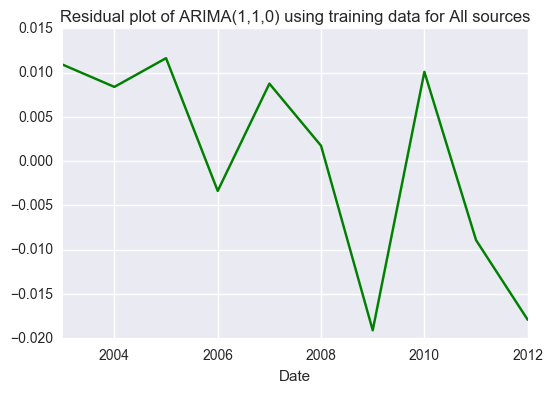

In [443]:
#Plot residuals for ARIMA(1,1,2)
plt.figure(1)
arima110_allsources.resid.plot(color="green")
plt.title('Residual plot of ARIMA(1,1,0) using training data for All sources')

The above ARIMA(1,1,2) and ARIMA(1,1,0) models on the post-2002 to 2012 training set are not predictive. The AR(1) coefficient is insignificant and the MA coefficients are significant in the case of the ARIMA(1,1,2) model, indicating residuals remain influential. Moreover, the mean absolute error of the model increases to above .52 for each of these alternative ARIMA models. 

Amongst the models attempted above, the best performer turned out to be the AR(1) model given the significance of the AR coefficient and the low mean absolute error of the model. The ARIMA(1,1,1) also produced a similarly low mean absolute error, but an insignificant AR coefficient. 

Show the forecasted results for the next 3 years based on the ARIMA (1,1,1) model on All Sources

In [467]:
from statsmodels.tsa.arima_model import ARIMAResults

pred_arima111_allsources = arima100_allsources.forecast(steps=5, exog=None, alpha=0.05)
for i in range(1,5):
    print pred_arima111_allsources[i]



#Take cumulative sum of predicted differences
#pred_arima111_allsources_sum = pred_arima111_allsources.cumsum()
#print pred_arima111_allsources_sum.head()

#Add cumulative values to the base number
#pred_arima111_allsources = pd.Series(allsourcesdata['co2permwh'].ix[0], index=natgasdata.index)
#pred_arima111_allsources = pred_arima111_allsources.add(pred_arima111_allsources[1],fill_value=0)
#print pred_arima111_allsources.tail()

[ 0.01426475  0.0201734   0.02470727  0.0285295   0.03189695]
[[ 0.5048973   0.56081409]
 [ 0.49331655  0.57239484]
 [ 0.48443033  0.58128106]
 [ 0.4769389   0.58877249]
 [ 0.47033882  0.59537257]]


IndexError: tuple index out of range

Plot the predicted and forecasted values using the ARIMA(1,1,1) on All Sources trained on 2002 to 2012 data

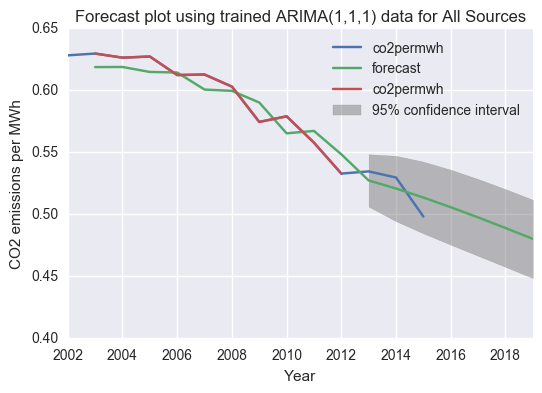

In [461]:
fig, ax = plt.subplots()
ax = allsources['2002':'2015'].plot(ax=ax)
fig = arima111_allsources.plot_predict(1, 17, ax=ax, plot_insample=True)
plt.title('Forecast plot using trained ARIMA(1,1,1) data for All Sources')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')

Train ARIMA models on Natural Gas data from 2001 to 2012. Test on 2013 to 2015 period

In [450]:
#Assign training set to values between years 2001 and 2013
natgas_train = natgas['2001':'2012']
print natgas_train.head(1)
print natgas_train.tail(1)
#Assign test set to years 2013 to 2015
natgas_test = natgas['2013':]
print natgas_test.tail(2)

Date
2001-12-31    0.574448
Name: co2permwh, dtype: float64
Date
2012-12-31    0.459449
Name: co2permwh, dtype: float64
Date
2014-12-31    0.456334
2015-12-31    0.450779
Name: co2permwh, dtype: float64


Test performance of training set using data post-2001 on Natural Gas using the AR(1) model.

In [452]:
from statsmodels.tsa.arima_model import ARIMA
arima100_natgas = sm.tsa.ARIMA(natgas_train, (1, 0, 0)).fit()

pred_arima100_natgas = arima100_natgas.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(natgas_test, pred_arima100_natgas))
arima100_natgas.summary()

('Mean absolute error: ', 0.0072289263206427217)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              co2permwh   No. Observations:                   12
Model:                     ARMA(1, 0)   Log Likelihood                  34.139
Method:                       css-mle   S.D. of innovations              0.012
Date:                Thu, 22 Dec 2016   AIC                            -62.279
Time:                        17:14:26   BIC                            -60.824
Sample:                    12-31-2001   HQIC                           -62.817
                         - 12-31-2012                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.5144      0.050     10.366      0.000         0.417     0.612
ar.L1.co2permwh     0.9722      0.039     24.998      0.000         0.896     1.048
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0286           +0.0000j            1.0286            0.0000
-----------------------------------------------------------------------------
"""

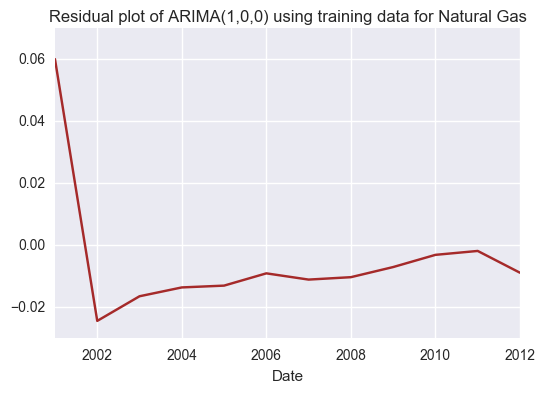

In [453]:
#Plot residuals for ARIMA(1,0,0)
plt.figure(1)
arima100_natgas.resid.plot(color="brown")
plt.title('Residual plot of ARIMA(1,0,0) using training data for Natural Gas')

The AR(1) trained model on Natural Gas performed well with a low Mean absolute error and significant AR coefficient.  However, residual plot shows a kink at the start of the training series.  Try ARIMA(1,1,1) to detrend data and reduce the influence of the residuals.

In [454]:
from statsmodels.tsa.arima_model import ARIMA
arima111_natgas = sm.tsa.ARIMA(natgas_train, (1, 1, 1)).fit()

pred_arima111_natgas = arima111_natgas.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(natgas_test, pred_arima111_natgas))
arima111_natgas.summary()

('Mean absolute error: ', 0.46794167952458093)


/Users/dalvarez83/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  45.221
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 22 Dec 2016   AIC                            -82.441
Time:                        17:21:46   BIC                            -80.850
Sample:                    12-31-2002   HQIC                           -83.445
                         - 12-31-2012                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0135      0.005     -2.558      0.034        -0.024    -0.003
ar.L1.D.co2permwh     0.6636      0.253      2.619      0.031         0.167     1.160
ma.L1.D.co2permwh     0.9995      0.476      2.100      0.069         0.067     1.932
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5070           +0.0000j            1.5070            0.0000
MA.1           -1.0005           +0.0000j            1.0005            0.5000
-----------------------------------------------------------------------------
"""

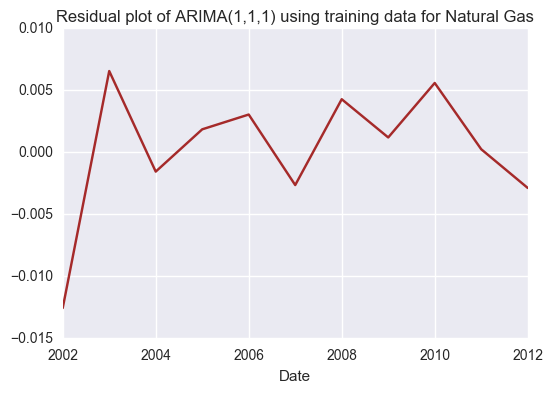

In [455]:
#Plot residuals for ARIMA(1,1,1)
plt.figure(1)
arima111_natgas.resid.plot(color="brown")
plt.title('Residual plot of ARIMA(1,1,1) using training data for Natural Gas')

The trained ARIMA(1,1,1) on Natural Gas performed less well with a higher mean absolute error than the AR(1) model, and a significant MA coefficient. However, the AR coefficient remains significant. Try ARIMA(1,1,2) to remove the influence of the residuals.

In [456]:
from statsmodels.tsa.arima_model import ARIMA
arima112_natgas = sm.tsa.ARIMA(natgas_train, (1, 1, 2)).fit()

pred_arima112_natgas = arima112_natgas.predict(
    '2013-12-31',
    '2015-12-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(natgas_test, pred_arima112_natgas))
arima112_natgas.summary()

('Mean absolute error: ', 0.46733330385580135)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.co2permwh   No. Observations:                   11
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  43.274
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 22 Dec 2016   AIC                            -76.547
Time:                        17:28:55   BIC                            -74.558
Sample:                    12-31-2002   HQIC                           -77.801
                         - 12-31-2012                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.0112      0.002     -5.187      0.001        -0.015    -0.007
ar.L1.D.co2permwh     0.9531      0.140      6.794      0.000         0.678     1.228
ma.L1.D.co2permwh  2.824e-08      0.266   1.06e-07      1.000        -0.522     0.522
ma.L2.D.co2permwh    -1.0000      0.266     -3.753      0.007        -1.522    -0.478
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0492           +0.0000j            1.0492            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

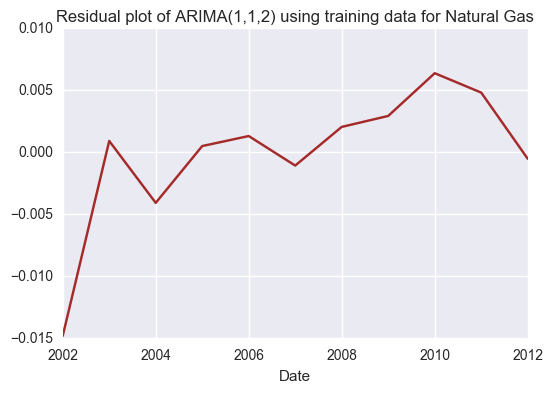

In [468]:
#Plot residuals for ARIMA(1,1,2)
plt.figure(1)
arima112_natgas.resid.plot(color="brown")
plt.title('Residual plot of ARIMA(1,1,2) using training data for Natural Gas')

Predict future results using trained ARIMA(1,1,2)

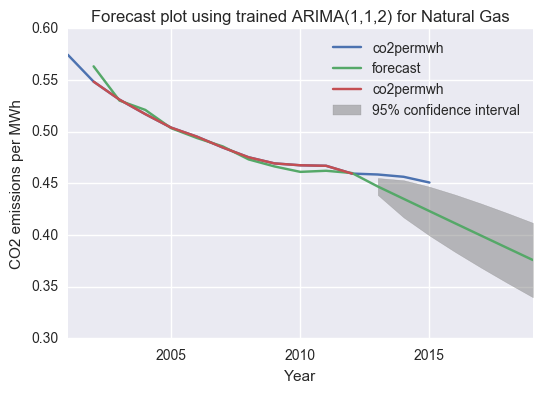

In [460]:
fig, ax = plt.subplots()
ax = natgas['2001':'2015'].plot(ax=ax)
fig = arima112_natgas.plot_predict(1, 18, ax=ax, plot_insample=True)
plt.title('Forecast plot using trained ARIMA(1,1,2) for Natural Gas')
plt.ylabel('CO2 emissions per MWh')
plt.xlabel('Year')

In [469]:
from statsmodels.tsa.arima_model import ARIMAResults

pred_arima112_natgas = arima112_natgas.forecast(steps=5, exog=None, alpha=0.05)
for i in range(1,5):
    print pred_arima112_natgas[i]

[ 0.00418929  0.00919216  0.01205435  0.01416145  0.01583428]
[[ 0.43872795  0.45514965]
 [ 0.41699097  0.45302358]
 [ 0.39948227  0.44673444]
 [ 0.38348459  0.43899645]
 [ 0.36836768  0.43043693]]


IndexError: tuple index out of range